### Updated Sample: 99,999 Objects
- Chosen from the DR11 test brick region (ignoring the core of Coma). 
- The objects in this sample are "ostensibly small"
- Every galaxy name should be unique -- based on "central" coordinates of galaxy with a resolution of 3.6"

#### Columns:

- _INIT --> initial ellipse parameters (BX, BY are in pixels)
    - BA_INIT
    - PA_INIT
    - SMA_INIT
    - BX_INIT
    - BY_INIT
    - RA_INIT
    - DEC_INIT
- GROUP -->
    - GROUP_ID --> ID of group
    - GROUP_NAME --> name of group
    - GROUP_MULT --> number of objects in group
    - GROUP_PRIMARY --> object with the largest initial diameter
    - GROUP_RA --> RA of group center
    - GROUP_DEC --> DEC of group center
    - GROUP_DIAMETER --> Size of group (Mpc?)
- RA, DEC, BX, BY --> the 'final' values for the galaxy
- _MOMENT -->
    - SMA_MOMENT --> SMA of galaxy ellipse
    - BA_MOMENT --> BA (axis ratio) of galaxy ellipse
    - PA_MOMENT --> PA (position angle) of galaxy ellipse
- COG_MTOT_ --> total magnitude in [FUV NUV], [GRIZ], [W1-4]
- COG_MTOT_ERR_ --> errors for the above columns; now fixed.
- SMA50_ --> half-light SMA length in each bandpass based on the fit to the curve of growth
- FLUX_AP00, FLUX_P01, FLUX_AP02, FLUX_AP03, FLUX_AP04 --> flux measurements within each aperture (which is some multiple of SMA_MOMENT -- 0.5, 1.0, 1.25, 1.5, 2.0)

 ### Load modules and packages and libraries and tables and...

In [1]:
import numpy as np
from rich import print
from matplotlib import pyplot as plt
%matplotlib inline
from astropy.table import Table, Column
import pandas as pd
import seaborn as sns
from astropy.coordinates import SkyCoord
from astropy import units as u
from matplotlib import colors

import os
homedir=os.getenv("HOME")

In [2]:
#read in the .fits file. first is ellipse fitting, second is SExtractor.
ellipse_tab=Table.read(homedir+'/Desktop/wisesize/SGA2025_tables/SGA2025-ellipse-v0.3.fits',hdu=1)
tractor_tab=Table.read(homedir+'/Desktop/wisesize/SGA2025_tables/SGA2025-ellipse-v0.3.fits',hdu=2)
sga2020 = Table.read(homedir+'/Desktop/wisesize/SGA2025_tables/sga2020.csv')

### Match SGA2025 and SGA2020 catalogs
#### NUMBER OF MATCHES: 83505

In [153]:
#isolate RA, DEC, R26_R [2020], R26_R [2025], PA_MOMENT, BA_MOMENT
#sga2020 is defined under the "Load Modules..." section
sga2020_tab = Table({'RA': sga2020['ra'],
                     'DEC': sga2020['dec'],
                     'R26_R': sga2020['sma_sb26'],
                     'pa': sga2020['pa'],
                     'ba': sga2020['ba']})

sga2025_sga2020_tab = Table({'RA': ellipse_tab['RA'],
                     'DEC': ellipse_tab['DEC'],
                     'R26_R': ellipse_tab['R26_R'],
                     'PA_MOMENT': ellipse_tab['PA_MOMENT'],
                     'BA_MOMENT': ellipse_tab['BA_MOMENT'],
                     'SGAID': ellipse_tab['SGAID']})

In [154]:
#create SkyCoord objects for each catalog...
coords2020 = SkyCoord(ra=sga2020_tab['RA']*u.deg, dec=sga2020_tab['DEC']*u.deg, frame='icrs')
coords2025 = SkyCoord(ra=sga2025_sga2020_tab['RA']*u.deg, dec=sga2025_sga2020_tab['DEC']*u.deg, frame='icrs')

#match coordinates in sga2025 to the closest in sga2020
idx, dist_2d, dist_3d = coords2025.match_to_catalog_sky(coords2020)

#add matched information to sga2025
sga2025_sga2020_tab['sga2020_R26_R'] = sga2020_tab['R26_R'][idx]
sga2025_sga2020_tab['sga2020_PA_MOMENT'] = sga2020_tab['pa'][idx]
sga2025_sga2020_tab['sga2020_BA_MOMENT'] = sga2020_tab['ba'][idx]
sga2025_sga2020_tab['Separation'] = dist_2d

In [155]:
#I'll keep matches with a separation of 3.6", in honor of the resolution of SGA2025 names
flag=(sga2025_sga2020_tab['Separation']<=3.6/3600.)

In [156]:
sga2025_sga2020_tab = sga2025_sga2020_tab[flag]

In [157]:
print('Matches:', len(sga2025_sga2020_tab))

Matches: 83505

### QA One
#### Separations between $\theta_{INIT}$, $\theta_{FINAL}$, and $\theta_{TRACTOR}$

#### Number of galaxies with no Tractor RA, DEC: 264

In [3]:
#ellipse_tab.columns --> RA_INIT, DEC_INIT, RA, DEC, RA_TRACTOR, DEC_TRACTOR

In [78]:
radec_init = ellipse_tab['RA_INIT'], ellipse_tab['DEC_INIT']
radec_final = ellipse_tab['RA'], ellipse_tab['DEC']
radec_tractor = ellipse_tab['RA_TRACTOR'], ellipse_tab['DEC_TRACTOR']

zero_flag = (radec_tractor[0]!=0) & (radec_tractor[1]!=0)

# Use your existing 'flag' to select objects
ra_init, dec_init = radec_init[0][zero_flag], radec_init[1][zero_flag]
ra_final, dec_final = radec_final[0][zero_flag], radec_final[1][zero_flag]
ra_tractor, dec_tractor = radec_tractor[0][zero_flag], radec_tractor[1][zero_flag]

delta_ra_init_final   = (ra_init - ra_final)
delta_dec_init_final = (dec_init - dec_final)
delta_ra_final_tractor = (ra_final - ra_tractor)
delta_dec_final_tractor = (dec_final - dec_tractor)
delta_ra_tractor_init = (ra_tractor - ra_init)
delta_dec_tractor_init = (dec_tractor - dec_init)

In [79]:
import warnings
warnings.filterwarnings("ignore")

df= pd.DataFrame({r'$\Delta$RA [INIT-FINAL]':delta_ra_init_final,
                  r'$\Delta$DEC [INIT-FINAL]':delta_dec_init_final,
                  r'$\Delta$RA [FINAL-TRACTOR]':delta_ra_final_tractor,
                  r'$\Delta$DEC [FINAL-TRACTOR]':delta_dec_final_tractor,
                  r'$\Delta$RA [TRACTOR-INITIAL]':delta_ra_tractor_init,
                  r'$\Delta$DEC [TRACTOR-INITIAL]':delta_dec_tractor_init})

#convert to arcseconds
df_arcsec = df * 3600

In [82]:
df_arcsec.columns

Index(['$\Delta$RA [INIT-FINAL]', '$\Delta$DEC [INIT-FINAL]',
       '$\Delta$RA [FINAL-TRACTOR]', '$\Delta$DEC [FINAL-TRACTOR]',
       '$\Delta$RA [TRACTOR-INITIAL]', '$\Delta$DEC [TRACTOR-INITIAL]'],
      dtype='object')

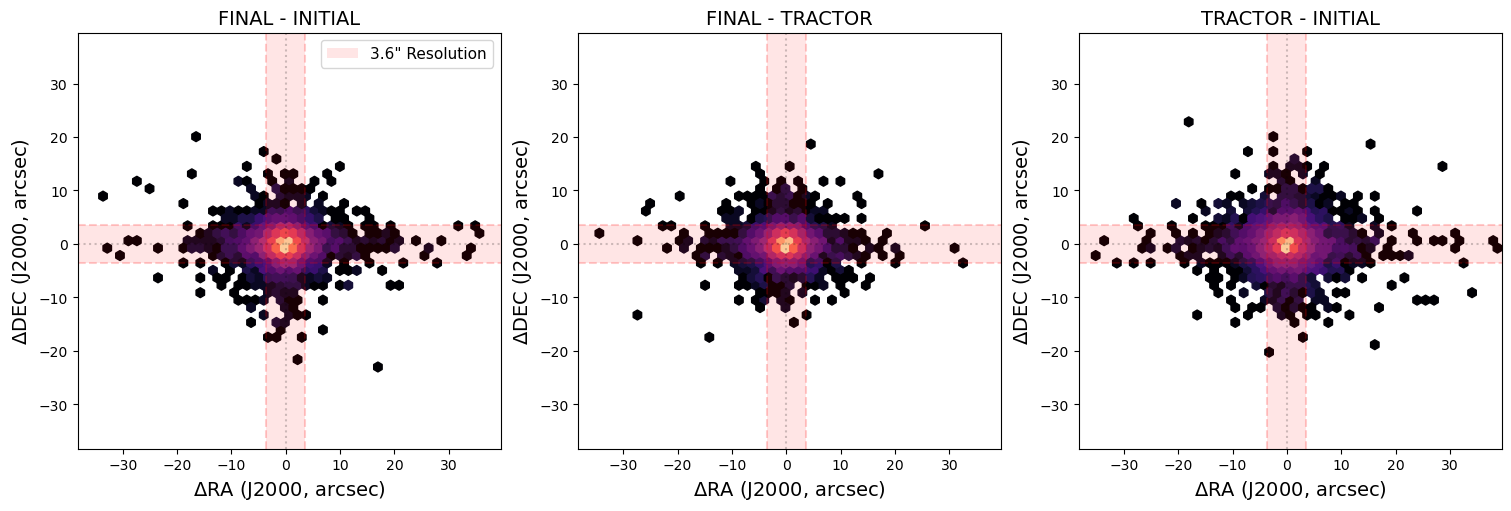

In [100]:
fig, axes = plt.subplots(1,3,figsize=(15,5),layout='constrained')
axs = axes.ravel()

columns = df_arcsec.columns

xmin=-38.3
xmax=39.52

axs[0].hexbin(df_arcsec[columns[0]], df_arcsec[columns[1]], mincnt=1,
                      gridsize=50, reduce_C_function=np.median, bins='log',
                      extent=(xmin, xmax, xmin, xmax), cmap='magma')

axs[1].hexbin(df_arcsec[columns[2]], df_arcsec[columns[3]], mincnt=1,
                      gridsize=50, reduce_C_function=np.median, bins='log',
                      extent=(xmin, xmax, xmin, xmax), cmap='magma')

axs[2].hexbin(df_arcsec[columns[4]], df_arcsec[columns[5]], mincnt=1,
                      gridsize=50, reduce_C_function=np.median, bins='log',
                      extent=(xmin, xmax, xmin, xmax), cmap='magma')

for ax in axs:

    ax.axhline(0,color='black', ls=':', alpha=0.2)
    ax.axvline(0,color='black', ls=':', alpha=0.2)

    lb_y = ax.axhline(-3.6, color='r', ls='--', alpha=0.2)
    lb_x = ax.axvline(-3.6, color='r', ls='--', alpha=0.2)
    up_y = ax.axhline(3.6, color='r', ls='--', alpha=0.2)
    up_x = ax.axvline(3.6, color='r', ls='--', alpha=0.2)

    ax.axhspan(ymin=-3.6, ymax=3.6, facecolor='red', alpha=0.1, label='3.6" Resolution')
    ax.axvspan(xmin=-3.6, xmax=3.6, facecolor='red', alpha=0.1)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(xmin, xmax)

    ax.set_xlabel(r'$\Delta$RA (J2000, arcsec)',fontsize=14)
    ax.set_ylabel(r'$\Delta$DEC (J2000, arcsec)',fontsize=14)

axs[0].legend(fontsize=11)

axs[0].set_title('FINAL - INITIAL',fontsize=14)
axs[1].set_title('FINAL - TRACTOR',fontsize=14)
axs[2].set_title('TRACTOR - INITIAL',fontsize=14)

plt.show()

#### Outliers

In [88]:
for column in df.columns:
    sep_flag=(df_arcsec[column]>3.6)  #3.6 arcsec
    sep_flag2=(df_arcsec[column]>10.0) #5.0 arcsec
    if np.sum(sep_flag)>0:
        sganame=ellipse_tab['SGAID'][zero_flag]
        sganame1=sganame[sep_flag]
        sganame2=sganame[sep_flag2]
        print(f'# Galaxies with separation > 3.6" for {column}: {len(sganame1)}')
        print(f'Galaxies with separation > 5": {np.asarray(sganame2)}')
        print()

# Galaxies with separation > 3.6" for $\Delta$RA [INIT-FINAL]: 645

Galaxies with separation > 5": [    103     694     724    1100    1278    1486    2574    2689    3058
    8859    8953    9057    9085   11900   25156   25976   26145   26479
   26558   29374   30946   31013   34333   38017   46591   47204   48334
   48976   49198   58225   63511   66614   79880   87788   97672  106111
  109586  117355  127101  149939  149963  159778  165425  183821  240525
  281469  309057  318531  318967  320946  355228  411581  483164  505447
  592341 1334249 1334306 3138111 3140265 3140300 3140941 3141784 3142313
 3144296 3145325 3145412 3146552 3146719 3146981 3147316 3147525 3148027
 3148191 3148307 3149899 3178957 3184790 3184793 3687798 4092379 4093144
 4135422 4195999 4199916 4242191 4257753 4692444 4744398 4765579 4783533
 4783820 4886922 4903100 4981784 5045342]

# Galaxies with separation > 3.6" for $\Delta$DEC [INIT-FINAL]: 258

Galaxies with separation > 5": [   1024    2673    2901   12228   35478   51027   62666   83940   92702
  180295  200999  233090  321326  364796  372261  584679  592524 4197693
 4694238 4722067 4815735 4906401 4929921 4932054 5053942]

# Galaxies with separation > 3.6" for $\Delta$RA [FINAL-TRACTOR]: 476

Galaxies with separation > 5": [    792    9019   25147   25156   26708   48514   83053  131077  159865
 3138450 3140265 3140301 3144019 3144951 3145758 3145940 3145943 3146719
 3146877 3147448 3147482 3150683 3154557 3342629 3614027 3616132 3790854
 4095354 4136122 4163287 4177628 4196779 4196964 4368867 4695456 4697624
 4746038 4792838 4815727 4829866 4853720 4853861 4856588 4863130 4877980
 4879375 4925062 4933783 4971445 4997325 5018061 5022464 5049576 5053545
 5053863 5054048]

# Galaxies with separation > 3.6" for $\Delta$DEC [FINAL-TRACTOR]: 181

Galaxies with separation > 5": [ 298955  306098  333799 3142036 3150076 3349248 3616132 4715680 4739900
 4831236 4880070 4885725 4931342 4933549 4998087]

# Galaxies with separation > 3.6" for $\Delta$RA [TRACTOR-INITIAL]: 851

Galaxies with separation > 5": [    398     608    1024    1051    1265    1323    1409    1592    2300
    2469    2527    2580    2584    2742    2777    2793    2802    2988
    8864    8895    8902    8913    8956   11901   25252   25592   26048
   26843   29250   33209   34311   35478   36805   41335   43538   55611
   57899   65264   72133   74448  103364  116612  120302  125884  143140
  145925  146972  151322  156362  159624  162604  169514  192073  235625
  240674  273828  307918  388119  388929  590960  592524  916329  925021
 3139078 3142347 3143881 3143926 3143977 3144583 3144638 3145687 3146919
 3147428 3147632 3147970 3148196 3148307 3149170 3150760 3156129 3171356
 3177950 3178720 3197766 3258033 3633252 4130191 4196336 4212821 4576928
 4711058 4739331 4739900 4742504 4742881 4757584 4758662 4764487 4767262
 4769041 4790443 4806251 4811558 4835287 4854657 4854854 4872838 4886733
 4887230 4909976 4910217 4923388 4923761 4924235 4927661 4928008 4950653
 4956190 4994592 4995718 5006254 5020025 5021788 5028000 5045868 5046945
 5052188 5053942 5053996 5054286]

# Galaxies with separation > 3.6" for $\Delta$DEC [TRACTOR-INITIAL]: 563

Galaxies with separation > 5": [   1080    1154    9034   11949   51249   78420   96654  131797  153168
  156333  188869  213883  254462  257382  286571  313274  354075  355737
  356684  363769  364212  381072  383586  461811  469147  590982  938695
 1267411 1282529 3145412 3169352 3169449 3349244 3689016 4517102 4688085
 4757471 4757584 4760795 4784304 4810108 4811364 4840590 4854657 4879133
 4886139 4976564 4997130 4998700 5054651 5056445]

### QA Two
#### Separations between BAPA [SGA2025] and BAPA [SGA2020]
 - Check for systematic offsets

In [158]:
#ellipses are only unique up to 180 degrees...0<PA<180

ba_sga2020, pa_sga2020 = sga2025_sga2020_tab['sga2020_BA_MOMENT'], sga2025_sga2020_tab['sga2020_PA_MOMENT']
ba_sga2025, pa_sga2025 = sga2025_sga2020_tab['BA_MOMENT'], sga2025_sga2020_tab['PA_MOMENT']

diff_ba = ba_sga2025-ba_sga2020
relative_diff_ba = diff_ba/ba_sga2020

#for PA, compare cos(2*difference)
#if they are nearly 90 degrees separated, then |np.cos(2*difference)| will be ~1
diff_pa = np.cos(2*(pa_sga2025-pa_sga2020))

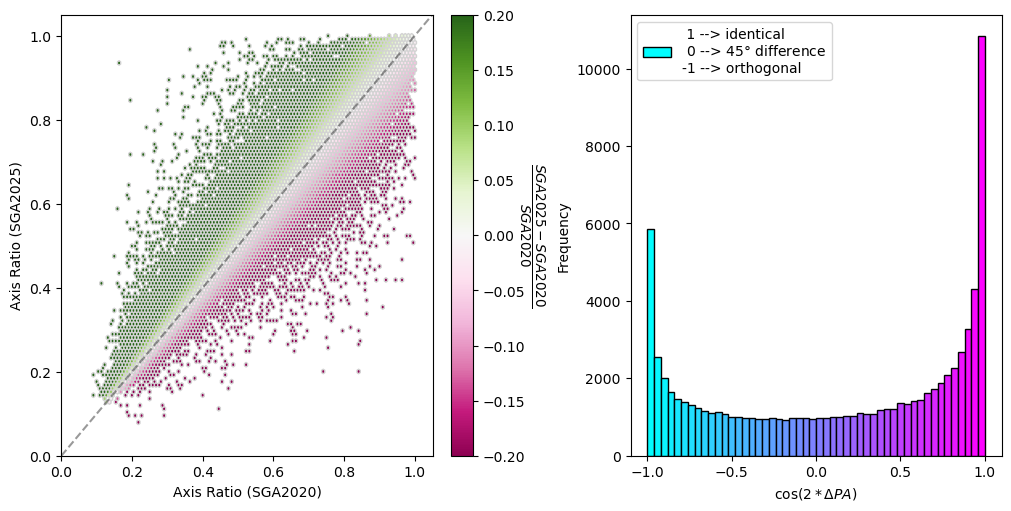

In [213]:
###
#AXIS RATIO
###
fig, axes = plt.subplots(1,2, figsize=(10, 5), layout='constrained')
#gs = fig.add_gridspec(2, 2)
axs = axes.ravel()
'''
axs = [fig.add_subplot(gs[0, 0]),   # top-left
       fig.add_subplot(gs[0, 1]),   # top-right
       fig.add_subplot(gs[1, :])]   # bottom spanning both columns
'''
im1 = axs[0].hexbin(ba_sga2020, ba_sga2025, C=relative_diff_ba,
                    cmap='PiYG', vmin=-0.2, vmax=0.2, edgecolor='lightgray')
axs[0].axline([0,0],slope=1,color='black',ls='--',alpha=0.4)
axs[0].set_xlabel('Axis Ratio (SGA2020)')
axs[0].set_ylabel('Axis Ratio (SGA2025)')
axs[0].set_xlim(0,)
axs[0].set_ylim(0,)

cbar = fig.colorbar(im1, ax=axs[0])
cbar.set_label(r'$\frac{SGA2025-SGA2020}{SGA2020}$',fontsize=14,rotation=270,labelpad=15)

###
#POSITION ANGLE
###

#from matplotlib histogram documentation
N, bins, patches = axs[1].hist(diff_pa, bins=50,
                              edgecolor='black',
                              label=' 1 --> identical\n'
                                    f' 0 --> 45$\degree$ difference\n'
                                    '-1 --> orthogonal')

#normalize to min/max of data range
norm = colors.Normalize(vmin=-1, vmax=1)
cmap = plt.cm.cool

#get bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])

#loop over bins, not raw data
for center, patch in zip(bin_centers, patches):
    patch.set_facecolor(cmap(norm(center)))

axs[1].set_xlabel(r'$\cos(2* \Delta PA)$')
axs[1].set_ylabel('Frequency')
axs[1].legend()

plt.show()

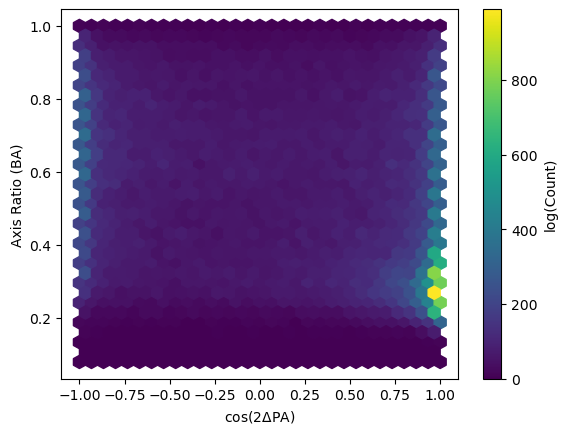

In [214]:
###
#PA vs. BA
###
fig = plt.figure()

hb = plt.hexbin(diff_pa, ba_sga2025, gridsize=30,
               cmap="viridis") #bins='log'

plt.xlabel(r'$\cos(2 \Delta \mathrm{PA})$')
plt.ylabel("Axis Ratio (BA)")

cbar = fig.colorbar(hb)
cbar.set_label("log(Count)")

plt.show()

#### Outliers

In [174]:
print(f'# galaxies with relative separation > 0.5 for BA: {len(relative_diff_ba[relative_diff_ba>0.5])}')
print(f'# galaxies with cos(2*diff) < 0 for PA: {len(diff_pa[diff_pa<0])}')
print(f'# galaxies with cos(2*diff) < -0.5 for PA: {len(diff_pa[diff_pa<0])}')
print('--------------------------------')

for i in range(len(ba_sga2025)):
    if np.abs(relative_diff_ba[i])>2.0:
        sganame = sga2025_sga2020_tab['SGAID'][i]
        print(f'Galaxy with relative difference > 2 for BA: {sganame}') 
        print(f'Separation (BA): {diff_ba[i]:.3f}')
        print()

print('--------------------------------')
for i in range(len(diff_pa)):
    if (diff_pa[i]<=-0.99999):
        sganame = sga2025_sga2020_tab['SGAID'][i]
        print(f'Galaxy with cos(2*diff) ~ -1.0 for PA: {sganame}') 
        print(f'Separation (PA): {diff_pa[i]:.3f}')
        print()

# galaxies with relative separation > 0.5 for BA: 1270

# galaxies with cos(2*diff) < 0 for PA: 34451

# galaxies with cos(2*diff) < -0.5 for PA: 34451

--------------------------------

Galaxy with relative difference > 2 for BA: 4710915

Separation (BA): 0.425

Galaxy with relative difference > 2 for BA: 4780846

Separation (BA): 0.524

Galaxy with relative difference > 2 for BA: 4785236

Separation (BA): 0.430

Galaxy with relative difference > 2 for BA: 4789535

Separation (BA): 0.297

Galaxy with relative difference > 2 for BA: 4811216

Separation (BA): 0.488

Galaxy with relative difference > 2 for BA: 4836238

Separation (BA): 0.541

Galaxy with relative difference > 2 for BA: 4872314

Separation (BA): 0.552

Galaxy with relative difference > 2 for BA: 4874351

Separation (BA): 0.431

Galaxy with relative difference > 2 for BA: 4883990

Separation (BA): 0.646

Galaxy with relative difference > 2 for BA: 4906118

Separation (BA): 0.320

Galaxy with relative difference > 2 for BA: 4909232

Separation (BA): 0.451

Galaxy with relative difference > 2 for BA: 4961043

Separation (BA): 0.773

--------------------------------

Galaxy with cos(2*diff) ~ -1.0 for PA: 3529038

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4682553

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4684356

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4687052

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4687799

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4688130

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4688624

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4692059

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4694069

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4700362

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4711088

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4715124

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4737557

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4746426

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4752435

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4755449

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4756530

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4759540

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4760710

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4766180

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4766476

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4773743

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4777964

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4783076

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4786033

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4786826

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4790361

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4798942

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4809928

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4818910

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4834215

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4835521

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4838795

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4843304

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4846288

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4846431

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4850185

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4853099

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4853337

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4853688

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4854246

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4858838

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4861443

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4864576

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4875726

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4876611

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4878431

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4887746

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4901321

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4904763

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4912427

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4915746

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4923349

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4923903

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4934034

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4935559

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4936967

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4937859

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4941535

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4944223

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4945311

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4945913

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4953631

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4958291

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4963206

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4968231

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4980032

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4982271

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4983030

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4986373

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4988854

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4995779

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4996099

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4997707

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 4998807

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 5002676

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 5002975

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 5003488

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 5010165

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 5013205

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 5020937

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 5024419

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 5025781

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 5044154

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 5045709

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 5046889

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 5048147

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 5049161

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 5050851

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 5051741

Separation (PA): -1.000

Galaxy with cos(2*diff) ~ -1.0 for PA: 5053280

Separation (PA): -1.000

### QA Three
#### SMA_INIT vs. SMA_MOMENT
---
- To-do: color-code by sample bitmask (nearstar, instar)

In [33]:
#diam_init = ellipse_tab['DIAM_INIT'] #arcminutes

sma_init = ellipse_tab['SMA_INIT']    #arcseconds
sma_final = ellipse_tab['SMA_MOMENT'] #arcseconds

diff_sma = sma_init-sma_final

relative_diff_sma = diff_sma/sma_init

In [34]:
#finding the median ratio (slope):
scale_median = np.median(sma_final / sma_init)
print(f"Median SMA scale factor: {scale_median:.3f}")

Median SMA scale factor: 0.731

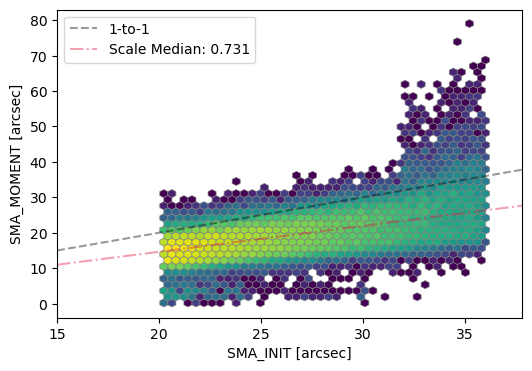

In [35]:
plt.figure(figsize=(6,4))

#mincnt=1 means ignore empty bins
hb = plt.hexbin(sma_init, sma_final, gridsize=40, cmap='viridis', mincnt=1, linewidths=0.5, edgecolors='gray',
               bins='log')

#plt.scatter(sma_init[~ba_flag], sma_final[~ba_flag], color='red', s=5)

plt.xlabel('SMA_INIT [arcsec]')
plt.ylabel('SMA_MOMENT [arcsec]')
plt.axline([0,0],slope=1,color='black',ls='--',alpha=0.4, label='1-to-1')
plt.axline([0,0], slope=scale_median, color='crimson', ls='-.',alpha=0.4,label=f'Scale Median: {scale_median:.3f}')
plt.xlim(15,)
#plt.ylim(0,92)
plt.legend(loc='upper left')
plt.show()

#### Outliers

In [36]:
print(f'[red] N Galaxies with relative separation > 50%: {len(ellipse_tab[np.abs(relative_diff_sma)>0.5])}')

for i in range(len(sma_init)):
    if (np.abs(relative_diff_sma[i])>10):
        sganame = ellipse_tab['SGAID'][i]
        print(f'Galaxy with relative separation > 1000% for SMA: {sganame}')
        print(f'Separation: {diff_sma[i]:.3f}')
        print()

 N Galaxies with relative separation > 50%: 3518

### QA Four
#### MTOT_ERR vs. MTOT in each wavelength band
#### [COG_MTOT_G - COG_MTOT_R] vs. [COG_MTOT_R - COG_MTOT_Z]
- 10 bands --> FUV, NUV, griz, W1-4
- Notes:
    - band label inconsistency:
        - MTOT_COG_[GRIZ]
        - MTOT_COG_ERR_[GRIZ]
    - ~~All COG_MTOT_ERR_* rows are 0~~    **Fixed!**

In [37]:
bands=['FUV','NUV','G','R','I','Z','W1','W2','W3','W4']   #uppercase GRIZ for MTOT

mtots = [f'COG_MTOT_{band}' for band in bands]
mtot_errs = [f'COG_MTOT_ERR_{band}' for band in bands]

chi_2s = [f'COG_CHI2_{band}' for band in bands]
n_dofs = [f'COG_NDOF_{band}' for band in bands]

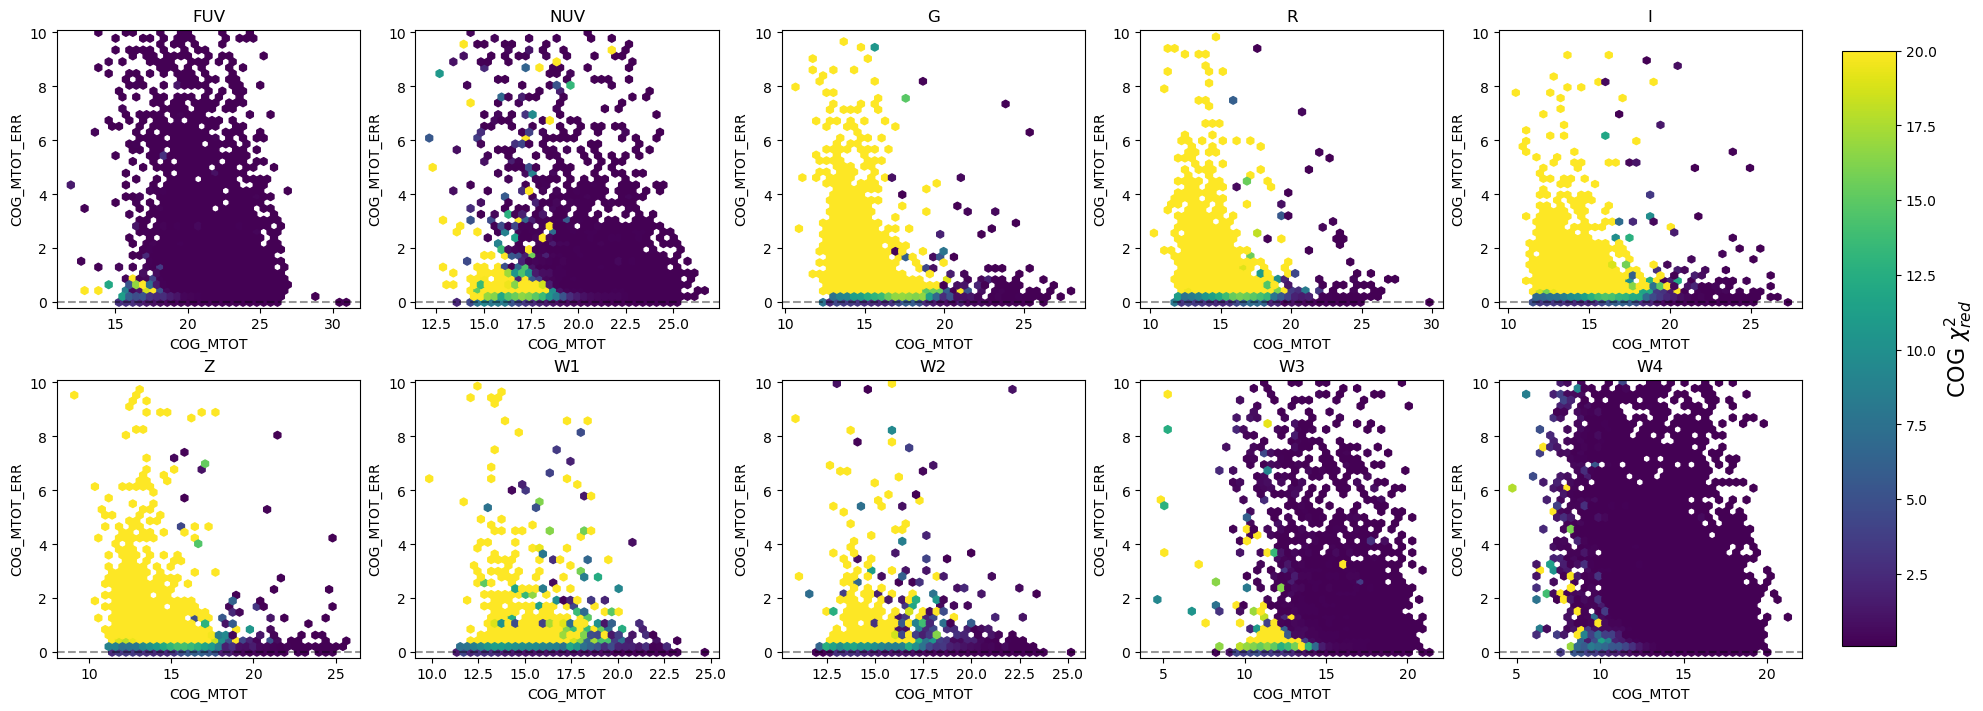

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 7), constrained_layout=True)
axes_flat = axes.ravel()

for i, ax in enumerate(axes_flat, start=1):
       
    red_chi2 = ellipse_tab[chi_2s[i-1]] / ellipse_tab[n_dofs[i-1]]

    ax.set_title(bands[i-1])
    ax.set_xlabel("COG_MTOT")
    ax.set_ylabel("COG_MTOT_ERR")
    
    err_flag = (ellipse_tab[mtot_errs[i-1]] < 10) & (ellipse_tab[mtots[i-1]] != 0)

    xdata = ellipse_tab[err_flag][mtots[i-1]]
    ydata = ellipse_tab[err_flag][mtot_errs[i-1]]
    cdata = red_chi2[err_flag]

    im1 = ax.hexbin(
        xdata, ydata, C=cdata,
        reduce_C_function=np.median,
        gridsize=40, cmap="viridis", vmin=0.1, vmax=20,
        extent=[xdata.min(), xdata.max(), ydata.min(), ydata.max()])

    ax.axhline(0, color='black', ls='--', alpha=0.4)
    ax.set_ylim(-0.2, 10.1)

cbar_ax = fig.add_axes([1.02, 0.085, 0.03, 0.85]) 
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label(r'COG $\chi^2_{red}$', fontsize=16)
cbar.solids.set(alpha=1)

plt.show()

### Outliers

In [39]:
for band in bands:
    large_err_flag = (ellipse_tab[f'COG_MTOT_ERR_{band}']>20)
    
    if np.sum(large_err_flag)>0:
        sganame = ellipse_tab['SGAID'][large_err_flag]

        print(f'Galaxies with >20 {band} MTOT ERR: {len(sganame)}') 
        print(f'{sganame.data}')
        print()

Galaxies with >20 FUV MTOT ERR: 784

[   8805    8868   22939   43540   47187   68843  125681  126375  153168
  202497  270295  397091  592448 1315185 3137443 3140156 3140770 3141708
 3143680 3145874 3146374 3150926 3156751 3161890 3171016 3177566 3178662
 3191657 3191790 3192214 3192470 3193248 3193990 3194150 3194621 3196337
 3196768 3197908 3207397 3237890 3503857 3517715 3530717 3533610 3637096
 3637656 3646502 3660657 3660671 3660936 3661359 3661816 3662777 3798860
 4092728 4129705 4131027 4131825 4162733 4163719 4163771 4164856 4166628
 4166745 4196322 4454725 4674903 4675681 4675982 4676830 4677105 4677268
 4677618 4677724 4679785 4680539 4681109 4681866 4681943 4682294 4682634
 4682668 4682697 4683107 4683110 4683764 4684414 4684582 4687179 4687225
 4687410 4687991 4688144 4688189 4688834 4688860 4689327 4689788 4690502
 4690534 4690621 4690717 4691135 4691322 4691590 4691752 4691764 4693401
 4693692 4694230 4694897 4695466 4696932 4697671 4698281 4698623 4698751
 4699850 4700375 4700999 4701314 4701333 4701761 4702361 4702606 4702828
 4703133 4703659 4703687 4704334 4705165 4705241 4705352 4706231 4706951
 4710002 4710391 4710506 4710698 4710849 4711078 4711232 4711497 4711579
 4711594 4711915 4712699 4713122 4713946 4715727 4716191 4717507 4717980
 4718293 4719464 4719654 4719673 4720357 4720373 4720453 4720720 4720740
 4721218 4721293 4721816 4721822 4721918 4722004 4722714 4725510 4725546
 4725648 4725798 4726236 4726380 4726525 4727265 4728523 4729085 4729095
 4729199 4729373 4731792 4732181 4732446 4733298 4733677 4733874 4733976
 4735585 4736901 4737808 4737907 4739404 4740102 4741067 4741868 4741921
 4742561 4742860 4743408 4744041 4745099 4745710 4746022 4746230 4746628
 4746855 4747881 4747982 4748544 4749040 4749075 4750493 4752026 4752337
 4752752 4753557 4753684 4754070 4754335 4754359 4755747 4755885 4756063
 4756241 4757148 4758457 4758878 4759691 4759736 4760238 4761968 4762268
 4762457 4762504 4763279 4763317 4763426 4763989 4763997 4764012 4764152
 4764776 4765002 4765747 4766577 4768256 4768325 4768353 4768359 4769137
 4769190 4769386 4769625 4769642 4771516 4772001 4772321 4772365 4772696
 4773266 4773706 4773720 4773831 4773989 4774264 4775522 4777132 4778993
 4779670 4780611 4781513 4781791 4781950 4782191 4782300 4782310 4783791
 4784292 4784431 4784442 4784816 4785413 4786286 4786867 4787405 4787561
 4787831 4788618 4788875 4789345 4790490 4790728 4791230 4791531 4792251
 4792814 4792872 4795160 4795821 4796483 4797811 4798245 4798651 4799007
 4799721 4800773 4801321 4801425 4801711 4801845 4802745 4802916 4803308
 4803688 4803959 4804367 4805457 4806009 4806472 4806736 4807089 4807324
 4807442 4807710 4808117 4808321 4808419 4808477 4808566 4808940 4809273
 4809633 4810113 4810287 4810372 4810396 4810848 4811796 4812450 4812665
 4812906 4813138 4813163 4813201 4814055 4814456 4814988 4815098 4816244
 4816246 4817518 4817624 4818167 4818218 4820660 4821232 4823429 4825750
 4826094 4827197 4827397 4827769 4828489 4829627 4830010 4830999 4831039
 4831788 4831800 4832556 4832832 4833062 4833241 4833925 4834049 4835075
 4835128 4835575 4835727 4835864 4836312 4836409 4836574 4836922 4837629
 4839092 4840012 4840422 4841014 4841056 4842139 4842743 4842811 4842963
 4843088 4843137 4844724 4846025 4846150 4846185 4846952 4847054 4847617
 4847710 4848008 4848307 4848474 4849385 4849770 4849926 4850008 4851715
 4851816 4852272 4853123 4853155 4853322 4853346 4854429 4854696 4854704
 4854900 4855857 4856062 4856596 4857252 4859167 4859265 4859379 4859771
 4859774 4859957 4860316 4861378 4862859 4863418 4863488 4863522 4864230
 4866698 4866956 4867218 4867553 4867837 4867876 4868222 4868345 4869059
 4871173 4871473 4871502 4872657 4874172 4874632 4875579 4876689 4876699
 4877356 4877701 4878065 4878608 4878648 4878832 4879138 4879218 4880198
 4880530 4880941 4881395 4881499 4881638 4883366 4883403 4883539 4883963
 4884260 4884955 4885329 4885560 4886433 4886631 4887319 4887426 4887698
 4887872 4888382 4889539 4889544 4890107 4890370 4892159 4

Galaxies with >20 NUV MTOT ERR: 249

[  23513   65956  210653  227206  314165  325833  330972  362209  397091
  405828  497071  505819  592347 1336754 1503316 1647695 3140781 3142347
 3147483 3190226 3201620 3205338 3259373 3365230 3517131 3533756 3635778
 3666150 3689886 3713397 3903663 3923234 3944571 4092411 4101574 4102219
 4104993 4129559 4163099 4198352 4198576 4675673 4679509 4679716 4680284
 4680539 4686254 4687934 4690465 4693140 4694020 4694417 4695750 4697197
 4698074 4698520 4698851 4700401 4705793 4710997 4711195 4717812 4718527
 4718948 4720536 4720667 4723447 4723679 4727908 4728314 4733839 4734726
 4738672 4739609 4742413 4743856 4744326 4752366 4752707 4757262 4758696
 4760353 4761705 4762402 4764142 4766969 4767567 4769147 4769318 4769917
 4771896 4774157 4775101 4776479 4778982 4780168 4780487 4782174 4782291
 4782310 4782414 4783826 4784173 4788243 4789643 4789817 4791904 4792092
 4792157 4792472 4793476 4794239 4796483 4799260 4805248 4805373 4809414
 4810305 4810685 4814835 4815119 4818448 4820152 4823912 4828690 4828986
 4829483 4829513 4830081 4831050 4833974 4835681 4836453 4836629 4838172
 4838239 4838240 4839890 4841251 4844500 4847344 4851772 4852357 4853274
 4854859 4855785 4860785 4861865 4862696 4870227 4871452 4875869 4881427
 4882359 4883539 4884060 4885232 4885551 4886631 4887558 4888906 4890730
 4891111 4894781 4895704 4900838 4903356 4903899 4904556 4907277 4908907
 4908986 4909345 4910490 4917163 4917519 4918876 4921933 4924668 4924799
 4926541 4928291 4929647 4929889 4931155 4931526 4931581 4931681 4932576
 4933686 4934167 4934967 4937023 4937081 4937948 4944589 4948991 4949331
 4949366 4951460 4952072 4952263 4958101 4958622 4961405 4963489 4964545
 4965347 4968101 4968603 4970504 4971037 4971255 4973466 4977084 4978058
 4979120 4981314 4982398 4988791 4988996 4991046 4995238 4995745 5001544
 5002956 5003887 5012567 5013217 5013975 5014940 5018400 5019549 5020884
 5022400 5023560 5024420 5025141 5026596 5027622 5028942 5035193 5041810
 5045877 5046371 5048036 5048109 5048887 5055459]

Galaxies with >20 G MTOT ERR: 79

[   1024    1158    3004    3709   38685   41362   46277   52381   55723
   56288   57458   75953   87904   95828  120708  139899  180464  188869
  217075  237437  289427  396819  399276  405819  410742  411581  429024
  455517  464659  466994  501165  502356  584670  916329  942883  982101
 1073513 1271302 1277185 1278575 1278973 1780988 3139367 3147101 3147742
 3153469 3299351 3406857 3486259 3614026 3614027 3893850 4203482 4393393
 4716469 4736849 4744302 4751590 4760203 4789239 4802328 4824831 4850370
 4854025 4876472 4894535 4898256 4899849 4904831 4922903 4976749 4993801
 4994989 5003518 5010456 5023991 5046315 5052450 5054089]

Galaxies with >20 R MTOT ERR: 69

[   2110    9231   41362   43339   48713   50808   52381   56288   57458
   75953   87904   95828  149596  157297  162065  173236  186663  188869
  241005  242245  261356  295247  300277  327631  354075  363025  379791
  396819  440000  456771  466994  501165  916329  942883  982101  996981
 1271302 1278973 1315185 1352304 1780988 3139980 3147742 3148633 3189235
 3406857 3660593 3810091 4129737 4196733 4369544 4393393 4716469 4742012
 4760203 4824831 4854025 4898256 4901299 4903651 4922903 4957357 4987051
 4993801 4994989 5020401 5023991 5039644 5054089]

Galaxies with >20 I MTOT ERR: 91

[   2625    2690   12038   36362   41012   41362   52381   56288   58145
   59390   59451   60520   75953   78814   87904   95828  126375  161687
  173626  186663  235625  241005  313274  396819  397674  402628  406993
  409063  429496  439952  445718  447819  450453  456771  462254  464798
  942883  982101 1063314 1271302 1278973 1282983 1352304 2372133 3139949
 3140613 3143150 3149318 3158744 3179203 3198153 3614027 3614311 3810091
 4102020 4131027 4162756 4701300 4706860 4708663 4725809 4751590 4764953
 4775409 4783188 4783274 4797670 4803754 4811732 4824831 4832511 4835095
 4853633 4896857 4905103 4908701 4919180 4919864 4924093 4945681 4946849
 4964703 4987648 4992093 4996755 5001533 5017706 5033806 5050970 5053142
 5054089]

Galaxies with >20 Z MTOT ERR: 88

[   1158    1994    8912    9155   12038   36362   41362   43339   46728
   50808   57458   59451   75953  123394  129944  139899  153168  154133
  157297  161687  171858  173548  176488  176790  187365  188869  215542
  221882  235625  236477  237437  241005  245044  245347  312575  327631
  367405  396819  409063  427649  440000  450453  456771  457521  458524
  487015  501165  592353  916329  982101 1062900 1271302 1277185 1278973
 1281588 1315185 1352304 1647451 2391273 3141643 3146264 3147054 3147212
 3149318 3251048 3406857 4103526 4393393 4736849 4748365 4751590 4758534
 4760203 4768535 4824831 4839338 4854025 4901299 4903651 4916318 4922903
 4940749 4976749 4993801 5020051 5023991 5039644 5054089]

Galaxies with >20 W1 MTOT ERR: 134

[  12141   49198   66684  109586  139899  161687  162065  171400  240387
  245796  321177  453571  456503 1437115 3140013 3141269 3143910 3145811
 3146430 3147348 3147525 3167046 3169389 3198790 3252363 3253349 3613894
 3620696 3687981 3761906 3893850 4102809 4130064 4132845 4144996 4162831
 4257800 4260229 4677968 4686304 4687318 4687533 4692134 4692998 4693089
 4695343 4698864 4701512 4704073 4707936 4716033 4716321 4716404 4732276
 4736865 4741568 4741758 4744970 4748468 4759503 4761728 4766591 4770939
 4779527 4781526 4787095 4788712 4791071 4794731 4801899 4805559 4812847
 4813244 4831940 4835859 4840662 4847275 4853952 4854149 4859621 4863093
 4870687 4875961 4882827 4882963 4896332 4896850 4898575 4900941 4902373
 4902622 4905034 4908427 4908506 4909428 4910361 4912324 4920958 4923264
 4925686 4926310 4928432 4929137 4934594 4934855 4963312 4967765 4969902
 4971255 4978744 4980242 4982526 4987051 4990058 4990606 4993903 4999298
 5003048 5005106 5005771 5007306 5025198 5041305 5041755 5044639 5047450
 5050110 5052370 5053024 5054707 5054762 5055459 5055595 5056650]

Galaxies with >20 W2 MTOT ERR: 150

[   1610    2496    8943   33664   66684  131797  156001  171400  240387
  241005  245796  321177  323476  453571  455517  456503 1306572 1370381
 3140013 3141269 3142515 3145664 3145811 3146430 3146780 3146831 3149511
 3160201 3167046 3259191 3616132 3640099 3674944 3679415 3687981 3761906
 4102012 4102555 4102809 4144996 4162831 4211071 4562940 4626786 4686731
 4689225 4689739 4690477 4691484 4692998 4694875 4696300 4698902 4703197
 4710342 4711043 4716404 4722172 4736528 4737486 4739728 4741568 4741758
 4743950 4747688 4751923 4755572 4755644 4757370 4759191 4759503 4765647
 4766591 4775461 4779974 4782923 4785654 4789623 4791392 4792612 4805559
 4808969 4809121 4810566 4819170 4820601 4827552 4835235 4844838 4846062
 4849391 4859621 4860592 4862831 4863594 4864104 4866320 4870687 4875961
 4882963 4885808 4891091 4895764 4896371 4898575 4900941 4901784 4902373
 4902622 4904571 4908506 4909428 4910361 4926310 4928432 4939815 4941267
 4941399 4942437 4945817 4948640 4956384 4957899 4961171 4963312 4965162
 4976364 4982682 4985647 4987201 5000445 5004302 5005771 5006386 5007306
 5010783 5011962 5020321 5020497 5022094 5025198 5026183 5026859 5034093
 5034280 5040031 5041755 5052370 5056421 5056641]

Galaxies with >20 W3 MTOT ERR: 365

[   2284  127101  142549  160045  163374  164656  171400  241905  292869
  311991  337341  359888  363769  397091  424436  424589  457040  577059
  577625 1228038 1278973 1282897 3136963 3146795 3147408 3147426 3148841
 3153680 3532098 3613894 3613895 3613985 3718749 3761970 3854952 3922786
 4196472 4196779 4200515 4672494 4677521 4678532 4678827 4679356 4683040
 4684296 4685585 4685980 4686204 4687044 4689064 4689315 4691030 4691846
 4694248 4695928 4696128 4696407 4696762 4697754 4699579 4700479 4701671
 4702174 4702263 4704176 4707610 4708356 4708995 4709338 4712513 4713649
 4714216 4716071 4717262 4717728 4718549 4719262 4719415 4720010 4720951
 4722391 4723899 4725521 4726878 4726901 4727178 4728583 4729624 4730969
 4731002 4731917 4733658 4734221 4734726 4736972 4737032 4737394 4739620
 4740174 4740567 4740874 4744277 4744587 4745943 4746009 4747353 4749174
 4750023 4752366 4753233 4754449 4758470 4761835 4763932 4764714 4765827
 4765895 4767013 4767193 4767452 4767552 4768494 4768684 4772129 4774088
 4774944 4778772 4778779 4779310 4780139 4780443 4781430 4782829 4783998
 4785456 4786065 4786239 4787095 4787890 4789676 4790198 4793232 4793777
 4796065 4798327 4798818 4799672 4800612 4801060 4802012 4803080 4804698
 4805373 4809291 4809536 4809950 4811472 4811553 4812749 4812906 4814220
 4814626 4814955 4815491 4816684 4818201 4824163 4826076 4826970 4827712
 4828781 4829593 4830054 4830591 4831344 4834201 4834524 4836251 4838019
 4840071 4842650 4842730 4844213 4845502 4845556 4846006 4846528 4847275
 4847980 4848872 4849797 4852123 4852356 4854867 4855176 4857248 4858464
 4860111 4860596 4860643 4861448 4861594 4861968 4863253 4864646 4866003
 4866281 4867096 4868461 4871452 4874285 4876231 4876674 4876902 4879734
 4880881 4881229 4883886 4884715 4885149 4885471 4886361 4887471 4888737
 4895019 4895983 4899983 4900459 4904352 4905230 4905558 4905731 4907148
 4908406 4908414 4911286 4911643 4913304 4917519 4919165 4922966 4923455
 4923686 4923761 4924084 4924754 4924933 4925154 4925252 4926211 4926494
 4926777 4927531 4928508 4931043 4931344 4932021 4932828 4935208 4935425
 4935519 4938687 4940312 4940474 4941922 4942051 4944159 4944719 4945942
 4946292 4946996 4947279 4948558 4949264 4949429 4949985 4950010 4950112
 4953256 4953270 4957403 4957480 4959444 4960252 4960834 4961000 4967960
 4968072 4970321 4970873 4971147 4971623 4975556 4975953 4979357 4981315
 4981776 4982115 4982240 4982266 4983507 4985563 4990231 4995171 4996755
 4998149 4998934 5000593 5001218 5001328 5002819 5002827 5004187 5004580
 5004788 5005802 5005946 5006079 5006941 5007205 5008970 5010551 5012929
 5017412 5017466 5020275 5021222 5022129 5022683 5025010 5025893 5028077
 5028904 5029372 5030097 5030380 5030572 5031404 5033037 5034447 5034538
 5034900 5038799 5039761 5040723 5040966 5041765 5042511 5044820 5045035
 5045121 5045288 5046569 5046616 5046705 5046833 5047269 5048242 5049384
 5050871 5051279 5054046 5054833 5054938]

Galaxies with >20 W4 MTOT ERR: 839

[   1672    1682    2989    9089   48110   57458   57701   78814   85202
  126254  126572  147359  191431  235625  243224  252358  336321  355899
  360768  444631  459047  997097 1029278 1228038 1335228 3137144 3140221
 3140780 3140851 3140865 3142288 3142876 3143234 3143257 3143422 3144231
 3146167 3146232 3148450 3148732 3149513 3149683 3149829 3154318 3177924
 3178855 3192093 3192347 3195010 3197970 3205933 3259927 3334264 3372993
 3419765 3515504 3619620 3635351 3660418 3660578 3660593 3661336 3689948
 3713408 3805888 3810091 3870659 3898391 4101424 4130068 4135214 4165296
 4166749 4199352 4436679 4517102 4674869 4676880 4677394 4677942 4677958
 4679001 4679573 4680621 4681182 4681248 4683257 4683465 4684665 4685021
 4686226 4686242 4686300 4686327 4688080 4689271 4690134 4690135 4690241
 4690761 4690770 4690806 4692358 4692488 4693005 4693503 4693905 4695086
 4695526 4695612 4696015 4696268 4697986 4698212 4698905 4699085 4699850
 4700687 4701353 4701892 4702458 4702603 4702718 4703176 4703261 4705145
 4705942 4708461 4709235 4709609 4710177 4710211 4710296 4711348 4711455
 4711895 4711954 4712454 4713210 4713911 4714430 4714521 4714725 4715034
 4715842 4716739 4716969 4718441 4718800 4718883 4718895 4719016 4719536
 4720085 4720468 4721050 4721120 4721336 4721456 4721691 4721738 4721997
 4722400 4723177 4723328 4723551 4723552 4724344 4724783 4724921 4724922
 4725481 4725568 4725602 4725970 4726473 4726612 4729536 4730002 4730039
 4730042 4731064 4731561 4731843 4732459 4732585 4733247 4733444 4733556
 4733880 4733956 4734045 4734214 4734626 4734739 4734863 4735365 4736418
 4736419 4737142 4737222 4737244 4737354 4737557 4738005 4738147 4738213
 4738353 4738652 4738741 4739330 4739438 4740740 4741396 4741694 4741786
 4741868 4742413 4743384 4743588 4744622 4744894 4744911 4745121 4745147
 4745578 4745689 4746418 4746901 4747133 4747409 4747620 4748106 4748709
 4748730 4749756 4749757 4749768 4750765 4750815 4751307 4751462 4751464
 4752413 4752608 4753240 4755324 4756467 4757472 4757545 4757779 4758050
 4758146 4758790 4760065 4760364 4760413 4761458 4761705 4761800 4762053
 4762714 4762822 4762840 4763447 4763995 4764010 4764728 4764834 4765226
 4765540 4765838 4766476 4766927 4767547 4767550 4767608 4767704 4768473
 4768925 4769471 4770231 4770465 4770672 4771194 4771249 4771353 4772398
 4772482 4772981 4773410 4774296 4775054 4775323 4775594 4775951 4776536
 4778857 4779236 4779567 4780096 4780624 4780770 4781030 4781998 4782824
 4782851 4783070 4783074 4783521 4783688 4783830 4783924 4785310 4785426
 4785716 4787242 4787921 4788273 4788398 4789586 4790126 4790408 4790467
 4791442 4791642 4793716 4793770 4794625 4795170 4795178 4796429 4796982
 4797024 4797889 4798508 4799337 4799992 4800343 4802365 4802789 4803781
 4804260 4804461 4804741 4804812 4804924 4805262 4806394 4806423 4807360
 4807627 4808620 4809013 4809284 4809352 4809480 4810501 4810737 4811405
 4811494 4811884 4811973 4812411 4812906 4813004 4813106 4813197 4814050
 4814178 4814473 4815010 4816297 4816427 4818268 4821212 4821819 4823344
 4823356 4824850 4826072 4827011 4827022 4828215 4828392 4828437 4828856
 4829100 4829382 4829721 4829852 4830446 4830810 4830924 4830961 4831046
 4831441 4831652 4832661 4833384 4833589 4833699 4834030 4834414 4834871
 4835655 4837916 4838073 4838346 4838395 4838464 4839666 4839964 4840576
 4840676 4841259 4841738 4842457 4843460 4844227 4845206 4845602 4846645
 4847322 4849268 4850714 4850727 4851786 4852163 4852975 4854146 4854659
 4855725 4856075 4856107 4857458 4857473 4857656 4857659 4857820 4857942
 4858180 4858506 4859033 4859307 4859601 4859942 4860409 4861945 4862032
 4862035 4862326 4862746 4862869 4863540 4864297 4865295 4865654 4866608
 4866768 4867184 4867271 4867332 4867876 4868162 4868758 4870495 4871906
 4873110 4875688 4876287 4876363 4876603 4877246 4877558 4877612 4878343
 4878833 4878871 4878899 4879241 4879381 4879386 4879734 4879939 4880881
 4881630 4882583 4883224 4883492 4883599 4883694 4884763 4

#### g-r vs. r-z plot:

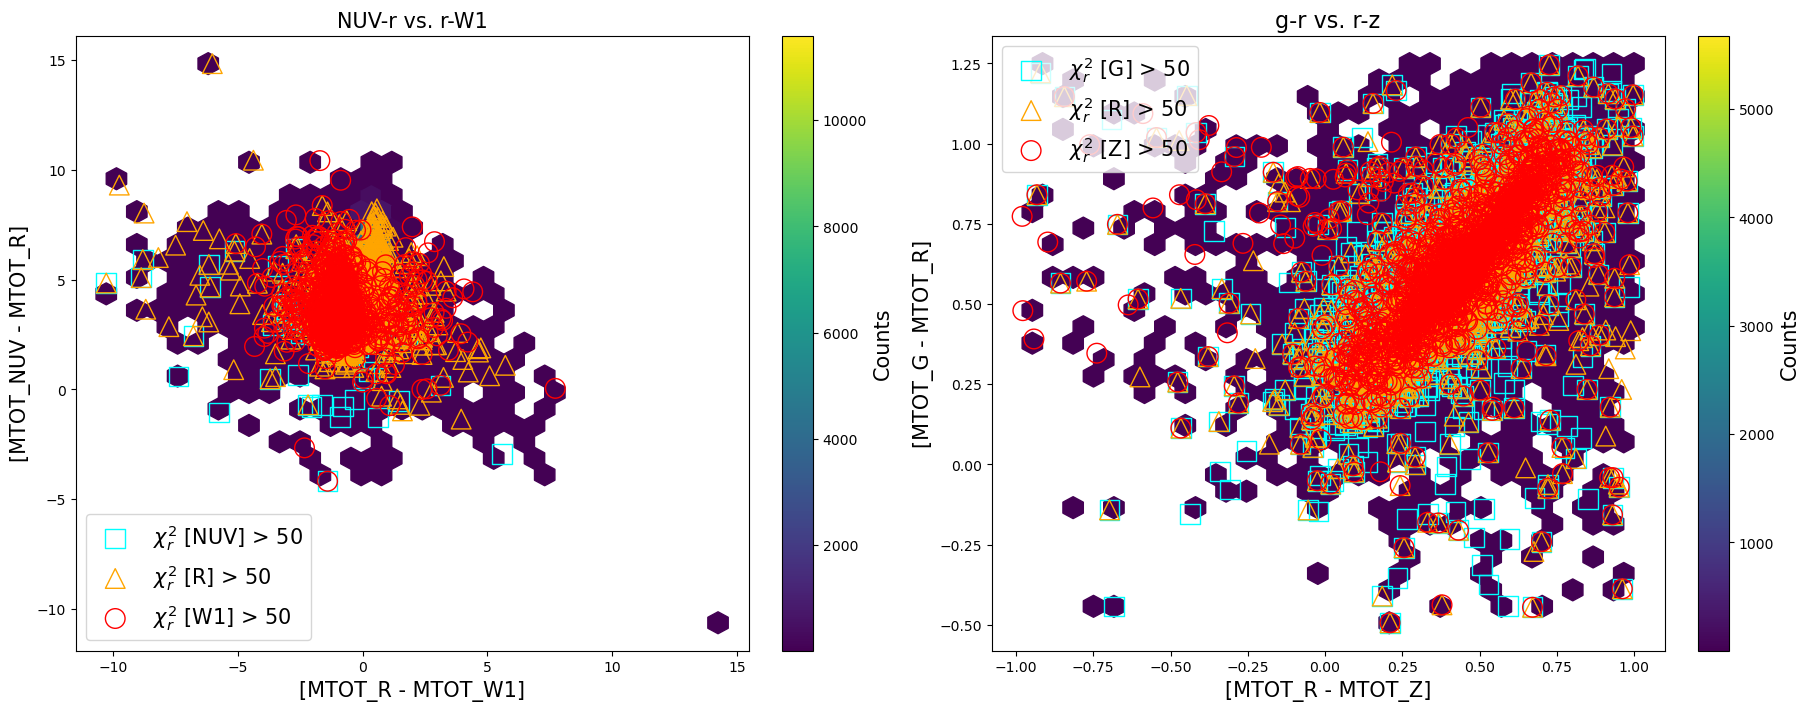

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7), constrained_layout=True)
ax1, ax2 = axes.ravel()

chi2_lim = 50

##############################
#left panel, NUV-r vs. r-W1
##############################

#removing cases with MTOT == 0, just in case
err_flag = (ellipse_tab['COG_MTOT_W1']!=0) & \
(ellipse_tab['COG_MTOT_R']!=0) & \
(ellipse_tab['COG_MTOT_NUV']!=0)

#defining some reduced chi^2 limit for the relevant bands' COGs
red_chi2_nuv = ((ellipse_tab['COG_CHI2_NUV']/ellipse_tab['COG_NDOF_NUV']) > chi2_lim) & err_flag 
red_chi2_r = ((ellipse_tab['COG_CHI2_R']/ellipse_tab['COG_NDOF_R']) > chi2_lim) & err_flag 
red_chi2_w1 = ((ellipse_tab['COG_CHI2_W1']/ellipse_tab['COG_NDOF_W1']) > chi2_lim) & err_flag 

nuv_r = ellipse_tab['COG_MTOT_NUV'] - ellipse_tab['COG_MTOT_R'] 
r_w1 = ellipse_tab['COG_MTOT_R'] - ellipse_tab['COG_MTOT_W1']

#hexbin density map...
im1 = ax1.hexbin(r_w1[err_flag], nuv_r[err_flag], gridsize=30, cmap='viridis', mincnt=1)
cb1 = fig.colorbar(im1, ax=ax1)
cb1.set_label('Counts', fontsize=15)

ax1.scatter(r_w1[red_chi2_nuv], nuv_r[red_chi2_nuv], marker='s',
            edgecolor='cyan', facecolor='none', s=200, label=fr'$\chi^2_r$ [NUV] > {chi2_lim}')
ax1.scatter(r_w1[red_chi2_r], nuv_r[red_chi2_r], marker='^',
            edgecolor='orange', facecolor='none', s=200, label=fr'$\chi^2_r$ [R] > {chi2_lim}')
ax1.scatter(r_w1[red_chi2_w1], nuv_r[red_chi2_w1], marker='o',
            edgecolor='red', facecolor='none', s=200, label=fr'$\chi^2_r$ [W1] > {chi2_lim}')

#labels and such
ax1.set_xlabel("[MTOT_R - MTOT_W1]",fontsize=15)
ax1.set_ylabel("[MTOT_NUV - MTOT_R]",fontsize=15)

ax1.legend(fontsize=15, loc='lower left')
ax1.set_title('NUV-r vs. r-W1', fontsize=15)

##############################
##############################
##############################

#removing cases with MTOT == 0, just in case
err_flag = (ellipse_tab['COG_MTOT_G']!=0) & \
(ellipse_tab['COG_MTOT_R']!=0) & \
(ellipse_tab['COG_MTOT_Z']!=0)

#defining the colors
g_r = ellipse_tab['COG_MTOT_G'] - ellipse_tab['COG_MTOT_R'] 
r_z = ellipse_tab['COG_MTOT_R'] - ellipse_tab['COG_MTOT_Z']

#color flag (to remove significant outliers)
color_flag = (g_r > -0.5) & (g_r < 1.25) & (r_z > -1.) & (r_z < 1.)

#defining some reduced chi^2 limit for the optical bands' COGs
red_chi2_g = ((ellipse_tab['COG_CHI2_G']/ellipse_tab['COG_NDOF_G']) > chi2_lim) & err_flag & color_flag
red_chi2_r = ((ellipse_tab['COG_CHI2_R']/ellipse_tab['COG_NDOF_R']) > chi2_lim) & err_flag & color_flag
red_chi2_z = ((ellipse_tab['COG_CHI2_Z']/ellipse_tab['COG_NDOF_Z']) > chi2_lim) & err_flag & color_flag

#right panel, the 'clips'
#hexbin density map...
im2 = ax2.hexbin(r_z[color_flag & err_flag], g_r[color_flag & err_flag], gridsize=30, cmap='viridis', mincnt=1)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('Counts', fontsize=15)

#flagged points with high-ish reduced chi^2
ax2.scatter(r_z[red_chi2_g], g_r[red_chi2_g], marker='s',
            edgecolor='cyan', facecolor='none', s=200, label=fr'$\chi^2_r$ [G] > {chi2_lim}')

ax2.scatter(r_z[red_chi2_r], g_r[red_chi2_r], marker='^',
            edgecolor='orange', facecolor='none', s=200, label=fr'$\chi^2_r$ [R] > {chi2_lim}')

ax2.scatter(r_z[red_chi2_z], g_r[red_chi2_z], marker='o',
            edgecolor='red', facecolor='none', s=200, label=fr'$\chi^2_r$ [Z] > {chi2_lim}')

#labels and such
ax2.set_xlabel("[MTOT_R - MTOT_Z]",fontsize=15)
ax2.set_ylabel("[MTOT_G - MTOT_R]",fontsize=15)

ax2.legend(loc='upper left',fontsize=15)
ax2.set_title('g-r vs. r-z', fontsize=16)

plt.show()

### QA Five
#### SMA50_ vs. SMA_MOMENT
 - This diagnostic will give us an idea of how these properties correlate
   - i.e., can SMA_MOMENT/2 be a reasonable proxy for the half-light radius?
 - Note that I specifically plot 2 * SMA50_ vs. SMA_MOMENT
 - Also note that SMA50 is based on the COG model. Half-light radius.
 - Bands: NUV, GRIZ, W1
 ---
 - To-do: cut on morphology?

In [41]:
bands=['NUV','G','R','I','Z','W1']   #uppercase GRIZ for SMA50

chi_2s = [f'COG_CHI2_{band}' for band in bands]
n_dofs = [f'COG_NDOF_{band}' for band in bands]
sma50 = [f'SMA50_{band}' for band in bands]

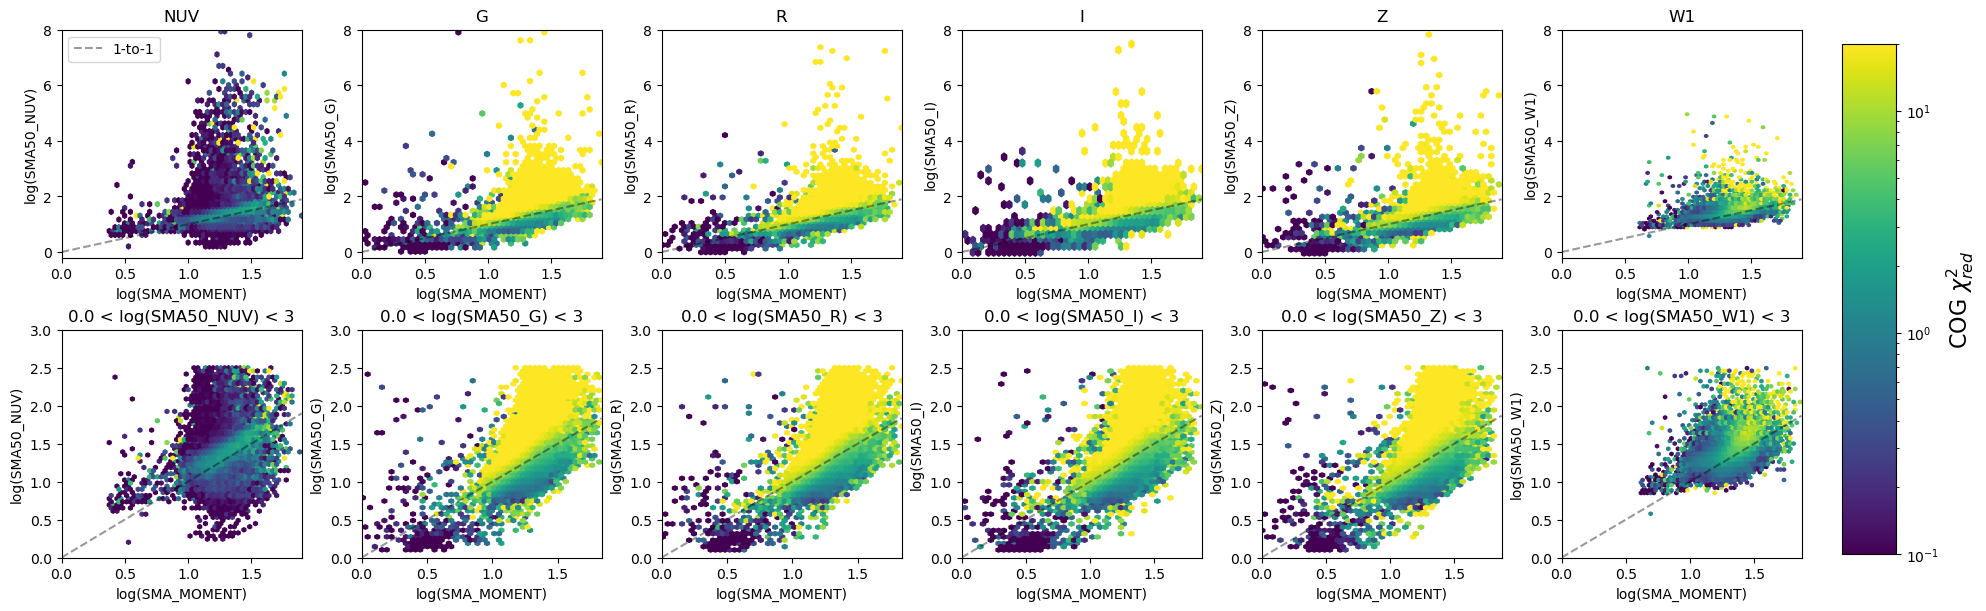

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(18, 6), constrained_layout=True)

axes_flat = axes.ravel()

for i, ax in enumerate(axes_flat, start=1):
    
    if i<7:
        index = i-1
        ylim = -0.2, 8
        title = bands[index]
        
        flag=np.ones(len(ellipse_tab), dtype=bool)
        
    else:
        index = i-7
        ylim = 0., 3
        title = f'{ylim[0]} < log(SMA50_{bands[index]}) < {ylim[1]}'
        
        flag=(np.log10(ellipse_tab[sma50[index]]*2)<2.5) & (np.log10(ellipse_tab[sma50[index]]*2)>0.1)
    
    #reduced chi-squared
    red_chi2 = ellipse_tab[chi_2s[index]][flag] / ellipse_tab[n_dofs[index]][flag]
    
    x=np.log10(ellipse_tab['SMA_MOMENT'])[flag]
    y=np.log10(ellipse_tab[sma50[index]]*2)[flag]
    
    xlim = 0, np.max(x)
    
    ax.set_title(title)
    ax.set_xlabel("log(SMA_MOMENT)")
    ax.set_ylabel(f"log(SMA50_{bands[index]})")
    im = ax.hexbin(x, y, C=red_chi2,
        gridsize=50, mincnt=1,
        reduce_C_function=np.median,
        bins='log', vmin=0.1, vmax=20)
    
    ax.axline([0,0],slope=1,color='black',ls='--',alpha=0.4, label='1-to-1')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if i==1:
        ax.legend(loc='upper left')

        
cbar_ax = fig.add_axes([1.02, 0.085, 0.03, 0.85]) 
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'COG $\chi^2_{red}$', fontsize=16)
cbar.solids.set(alpha=1)        

plt.show()

#### Outliers

In [43]:
for i, band in enumerate(bands):
    
    diff_sma = ellipse_tab['SMA_MOMENT'] - (2*ellipse_tab[sma50[i-1]])
    relative_diff_sma = diff_sma/ellipse_tab['SMA_MOMENT']
    
    flag50 = (np.abs(relative_diff_sma)>50)
    print(f'[yellow] Number of galaxies with relative separations > 50 for {band}: {np.sum(flag50)}')
    
    flag300 = (np.abs(relative_diff_sma)>3000.0)
    print(f'[yellow] Number of galaxies with relative separations > 3000.0 for {band}: {np.sum(flag300)}')
    
    galaxies=ellipse_tab[flag300]
    
    for galaxy in galaxies:
        sganame=galaxy['SGAID']
        print(f'Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_{band}: {sganame}')
        print(f'Separation: {galaxy["SMA_MOMENT"]-(2*galaxy[sma50[i-1]]):.2e}')
        print()

 Number of galaxies with relative separations > 50 for NUV: 49

 Number of galaxies with relative separations > 3000.0 for NUV: 4

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_NUV: 49198

Separation: -9.06e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_NUV: 4736849

Separation: -4.83e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_NUV: 4882963

Separation: -7.74e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_NUV: 5054762

Separation: -7.04e+04

 Number of galaxies with relative separations > 50 for G: 568

 Number of galaxies with relative separations > 3000.0 for G: 128

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 23513

Separation: -4.49e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 592347

Separation: -1.15e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 3142327

Separation: -1.08e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 3144156

Separation: -1.91e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 3144675

Separation: -1.18e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 3146727

Separation: -1.76e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 3146754

Separation: -4.55e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 3147483

Separation: -3.46e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 3190226

Separation: -3.94e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 3196768

Separation: -7.73e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 3517131

Separation: -1.14e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 3713397

Separation: -3.22e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 3923234

Separation: -1.24e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 3944571

Separation: -2.16e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4104993

Separation: -1.04e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4198352

Separation: -3.29e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4680539

Separation: -7.53e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4686780

Separation: -7.66e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4690465

Separation: -1.49e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4692413

Separation: -6.01e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4693140

Separation: -3.58e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4694020

Separation: -1.17e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4695750

Separation: -4.56e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4696944

Separation: -1.57e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4697197

Separation: -5.02e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4705145

Separation: -4.23e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4711195

Separation: -8.69e+07

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4712996

Separation: -2.97e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4713461

Separation: -1.04e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4717507

Separation: -8.17e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4720653

Separation: -2.04e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4723447

Separation: -2.26e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4729095

Separation: -1.73e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4737422

Separation: -6.90e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4738993

Separation: -1.29e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4742567

Separation: -3.41e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4744587

Separation: -1.18e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4748072

Separation: -1.27e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4752191

Separation: -3.27e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4754158

Separation: -7.69e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4760353

Separation: -2.93e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4761219

Separation: -2.66e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4761705

Separation: -7.52e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4763617

Separation: -8.34e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4769147

Separation: -2.97e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4769917

Separation: -7.47e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4776584

Separation: -1.06e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4778982

Separation: -7.45e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4779150

Separation: -2.27e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4779793

Separation: -9.13e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4782174

Separation: -2.82e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4783826

Separation: -1.27e+07

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4786143

Separation: -4.48e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4786429

Separation: -3.26e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4786545

Separation: -1.19e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4788035

Separation: -1.64e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4789668

Separation: -4.71e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4792685

Separation: -2.44e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4798264

Separation: -1.17e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4801581

Separation: -2.28e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4805373

Separation: -6.36e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4809414

Separation: -7.48e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4811440

Separation: -3.63e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4814835

Separation: -7.03e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4820152

Separation: -4.97e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4829513

Separation: -4.43e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4829910

Separation: -5.36e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4838239

Separation: -4.14e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4838677

Separation: -2.76e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4846832

Separation: -2.45e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4849385

Separation: -1.17e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4850092

Separation: -2.18e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4851021

Separation: -1.05e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4851772

Separation: -7.92e+07

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4852636

Separation: -3.77e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4861865

Separation: -7.51e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4862696

Separation: -5.88e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4863526

Separation: -1.97e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4864457

Separation: -3.66e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4876913

Separation: -1.89e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4877079

Separation: -5.84e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4880077

Separation: -4.38e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4883578

Separation: -1.02e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4884060

Separation: -1.28e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4886631

Separation: -7.58e+07

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4891111

Separation: -1.34e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4895704

Separation: -2.67e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4900838

Separation: -1.49e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4902246

Separation: -8.52e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4907943

Separation: -8.63e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4910490

Separation: -3.70e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4917519

Separation: -1.69e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4921384

Separation: -3.05e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4921933

Separation: -9.14e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4924799

Separation: -2.69e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4929018

Separation: -1.28e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4929647

Separation: -4.97e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4931526

Separation: -2.56e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4931681

Separation: -6.66e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4933686

Separation: -4.45e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4934967

Separation: -1.34e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4937023

Separation: -3.25e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4937948

Separation: -7.64e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4949683

Separation: -7.20e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4950574

Separation: -2.00e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4952072

Separation: -9.79e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4958622

Separation: -3.12e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4972358

Separation: -4.49e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4976401

Separation: -6.04e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4979120

Separation: -8.63e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4991046

Separation: -5.70e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4998736

Separation: -4.05e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 4999524

Separation: -1.83e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 5004421

Separation: -7.13e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 5013217

Separation: -2.02e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 5019549

Separation: -7.13e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 5031619

Separation: -1.62e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 5031864

Separation: -5.32e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 5035408

Separation: -1.97e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 5036870

Separation: -1.55e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 5043784

Separation: -7.04e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 5044838

Separation: -7.06e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 5044908

Separation: -1.23e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 5045740

Separation: -9.05e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 5045877

Separation: -9.08e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 5048887

Separation: -1.08e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 5049200

Separation: -1.03e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_G: 5052064

Separation: -8.63e+04

 Number of galaxies with relative separations > 50 for R: 125

 Number of galaxies with relative separations > 3000.0 for R: 25

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 41362

Separation: -4.63e+07

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 46277

Separation: -3.67e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 52381

Separation: -4.90e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 56288

Separation: -3.11e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 57458

Separation: -2.18e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 75953

Separation: -5.16e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 87904

Separation: -1.58e+08

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 139899

Separation: -8.95e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 455517

Separation: -8.18e+07

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 501165

Separation: -3.60e+07

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 942883

Separation: -7.26e+07

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 1278555

Separation: -1.86e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 1352304

Separation: -9.81e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 3406857

Separation: -7.81e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 3614027

Separation: -1.65e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 4393393

Separation: -1.50e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 4751590

Separation: -1.12e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 4760203

Separation: -9.33e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 4824831

Separation: -7.28e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 4854025

Separation: -3.63e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 4922903

Separation: -3.24e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 4976749

Separation: -8.17e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 4994989

Separation: -3.64e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 5023991

Separation: -7.22e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_R: 5046315

Separation: -1.82e+04

 Number of galaxies with relative separations > 50 for I: 87

 Number of galaxies with relative separations > 3000.0 for I: 19

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_I: 41362

Separation: -1.52e+07

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_I: 43339

Separation: -1.35e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_I: 50808

Separation: -8.16e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_I: 52381

Separation: -6.92e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_I: 57458

Separation: -5.05e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_I: 75953

Separation: -8.88e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_I: 87904

Separation: -6.83e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_I: 186663

Separation: -1.15e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_I: 241005

Separation: -1.16e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_I: 379791

Separation: -1.71e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_I: 501165

Separation: -2.32e+07

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_I: 942883

Separation: -1.03e+07

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_I: 982101

Separation: -8.51e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_I: 996981

Separation: -5.23e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_I: 1352304

Separation: -3.56e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_I: 4393393

Separation: -1.80e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_I: 4760203

Separation: -1.59e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_I: 4854025

Separation: -3.59e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_I: 4922903

Separation: -1.73e+07

 Number of galaxies with relative separations > 50 for Z: 60

 Number of galaxies with relative separations > 3000.0 for Z: 11

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_Z: 36362

Separation: -6.40e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_Z: 41362

Separation: -2.28e+07

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_Z: 75953

Separation: -4.59e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_Z: 87904

Separation: -2.44e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_Z: 173626

Separation: -1.70e+08

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_Z: 186663

Separation: -2.09e+07

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_Z: 241005

Separation: -2.51e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_Z: 396819

Separation: -1.82e+08

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_Z: 409063

Separation: -9.45e+11

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_Z: 439952

Separation: -1.05e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_Z: 982101

Separation: -5.88e+05

 Number of galaxies with relative separations > 50 for W1: 114

 Number of galaxies with relative separations > 3000.0 for W1: 28

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 9155

Separation: -5.26e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 41362

Separation: -9.72e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 43339

Separation: -9.65e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 50808

Separation: -9.71e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 57458

Separation: -2.48e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 75953

Separation: -1.34e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 129944

Separation: -6.43e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 161687

Separation: -1.74e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 241005

Separation: -9.54e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 367405

Separation: -1.30e+08

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 396819

Separation: -6.17e+06

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 409063

Separation: -7.92e+07

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 501165

Separation: -1.33e+07

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 1281588

Separation: -3.13e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 1352304

Separation: -5.14e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 2391273

Separation: -1.18e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 3149318

Separation: -1.56e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 4103526

Separation: -3.80e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 4393393

Separation: -2.27e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 4748365

Separation: -5.24e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 4760203

Separation: -1.70e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 4768535

Separation: -6.33e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 4854025

Separation: -5.43e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 4903651

Separation: -4.58e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 4911312

Separation: -7.63e+04

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 4922903

Separation: -3.81e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 4976749

Separation: -2.16e+05

Galaxy with relative separations > 3000.0 between SMA_MOMENT and SMA50_W1: 5023991

Separation: -2.24e+05

### QA Six
#### Check that SMA_AP01 is the same as SMA_MOMENT

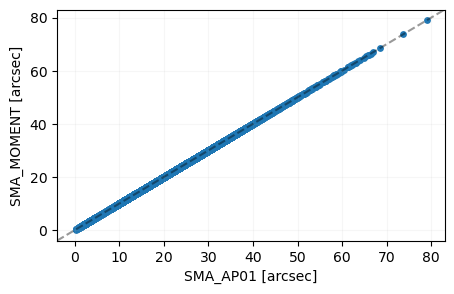

In [44]:
sma_ap1 = ellipse_tab['SMA_AP01']
sma_moment = ellipse_tab['SMA_MOMENT']

plt.figure(figsize=(5,3))
plt.scatter(sma_ap1, sma_moment,s=15)
plt.axline([0,0], slope=1, ls='--', color='black', alpha=0.4)
plt.xlabel('SMA_AP01 [arcsec]')
plt.ylabel('SMA_MOMENT [arcsec]')
plt.grid(alpha=0.1)
plt.show()

VAR check is complete. No penalty.

### QA Seven
#### MTOT vs. FLUX_AP04 fluxes (2x SMA_MOMENT)

In [45]:
bands=['FUV','NUV','G','R','I','Z','W1','W2','W3','W4']   #uppercase GRIZ for FLUX_AP04_ and COG_MTOT_

ap04s = [f'FLUX_AP04_{band}' for band in bands]
mtots = [f'COG_MTOT_{band}' for band in bands]

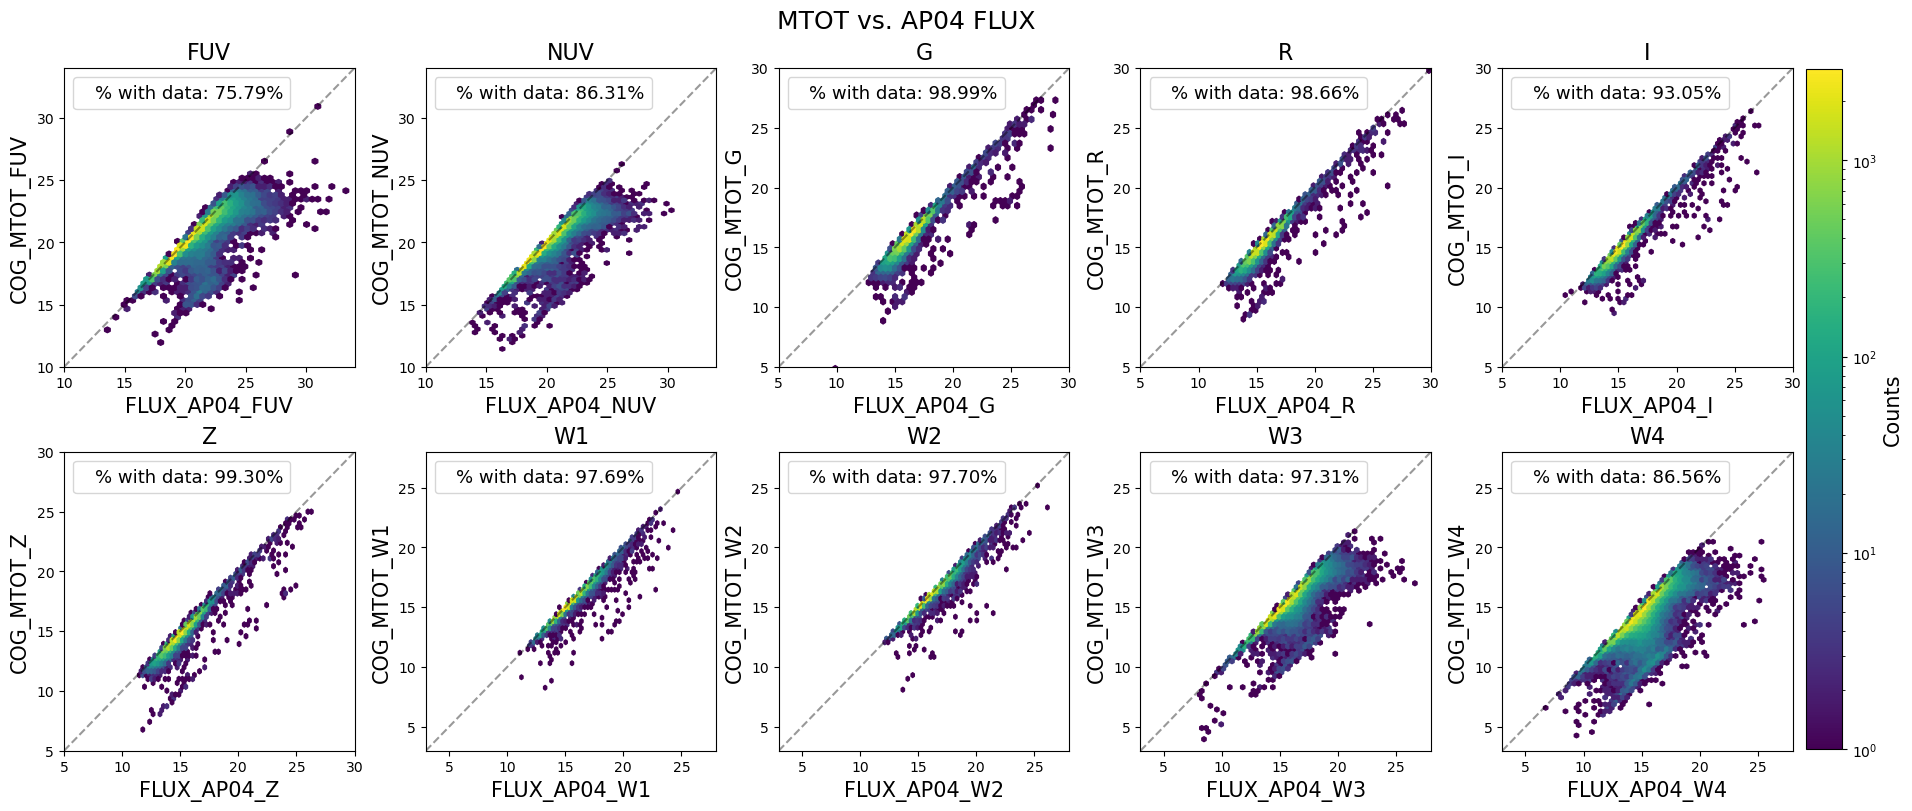

In [263]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 8), constrained_layout=True)

axes_flat = axes.ravel()

for i, ax in enumerate(axes_flat, start=1):
    ap04 = ap04s[i-1]
    mtot = mtots[i-1]
    
    err_flag = (ellipse_tab[mtot]!=0)
    
    ap04_mag = 22.5 - 2.5*np.log10(ellipse_tab[ap04])
    mtot_mag = ellipse_tab[mtot]
        
    ax.set_title(bands[i-1],fontsize=16)
    ax.set_xlabel(ap04, fontsize=15)
    ax.set_ylabel(mtot, fontsize=15)
    
    im=ax.hexbin(ap04_mag[err_flag], mtot_mag[err_flag],
        gridsize=50, mincnt=1,
        reduce_C_function=np.median,
        bins='log', label=f'% with data: {len(ap04_mag[err_flag])*100/len(ap04_mag):.2f}%')
    
    label_=''
    #if i==1:   
    #    label_='1-to-1'
    ax.axline([0,0],slope=1,color='black',alpha=0.4,ls='--',label=label_)
    
    if i<=2:
        ax.set_xlim(10,34)
        ax.set_ylim(10,34)
    
    elif i in [3,4,5,6]:
        ax.set_xlim(5,30)
        ax.set_ylim(5,30)
    
    else:       #i in [7,8,9,10]
        ax.set_xlim(3,28)
        ax.set_ylim(3,28)

    leg = ax.legend(loc='upper left', handlelength=0, fontsize=13, fancybox=True)
    leg.legendHandles[0].set_visible(False)   #set color marker to False
    
cbar_ax = fig.add_axes([1, 0.07, 0.02, 0.85]) 
cbar=fig.colorbar(im, cax=cbar_ax)
cbar.set_label(label=r'Counts', fontsize=15)

fig.suptitle(r'MTOT vs. AP04 FLUX',fontsize=18)

plt.show()

### QA Eight
#### Colors with MTOT vs. colors with all AP apertures
- Want to check whether aperture choice biases color
- NOTE: convert g-r color to magnitudes using [g-r] = -2.5*log$_{10}\Big(\frac{flux_g}{flux_r}\Big)$
     - calculating the fraction directly eliminates the need for zeropoints. :-)

In [47]:
#g-r (MTOT) vs. g-r (AP), and r-z (MTOT) vs. r-z (AP)?
#one panel per aperture -- AP00, AP01, AP02, AP03, AP04

In [267]:
apertures = ['00', '01', '02', '03', '04']

mtot_g = ellipse_tab['COG_MTOT_G']
mtot_r = ellipse_tab['COG_MTOT_R']
mtot_z = ellipse_tab['COG_MTOT_Z']

err_flag = (mtot_g!=0) & (mtot_r!=0) & (mtot_z!=0)

mtot_g_r = mtot_g[err_flag] - mtot_r[err_flag]
mtot_r_z = mtot_r[err_flag] - mtot_z[err_flag]

sganames = ellipse_tab['SGAID'][err_flag]

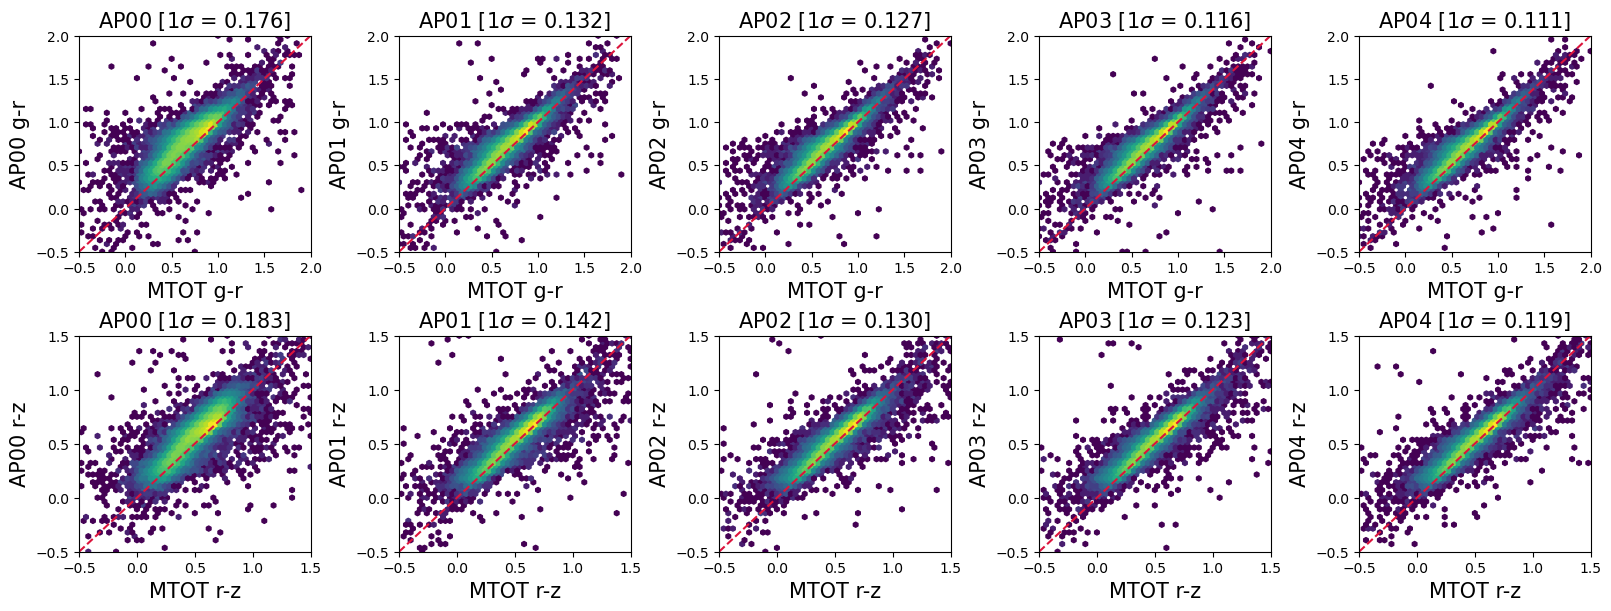

In [282]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 6), constrained_layout=True)
axes_flat = axes.ravel()

flagged_galaxies = []  #collect flagged galaxies to print later :)

for i, ax in enumerate(axes_flat, start=1):
    
    if i<6:
        ap_name=apertures[i-1]
    else:
        ap_name=apertures[i-6]
        
    ap_g = f'FLUX_AP{ap_name}_G'
    ap_r = f'FLUX_AP{ap_name}_R'
    ap_z = f'FLUX_AP{ap_name}_Z'
    
    g_r_ap = 2.5*-1*np.log10(ellipse_tab[ap_g]/ellipse_tab[ap_r])[err_flag]   #calculate color in magnitudes!
    r_z_ap = 2.5*-1*np.log10(ellipse_tab[ap_r]/ellipse_tab[ap_z])[err_flag]

    if i<6:
        ###############################
        ####         g-r           ####
        ###############################
        
        xmin=-0.5
        xmax=2
        
        #remove infinity values from difference
        diff = g_r_ap-mtot_g_r
        diff_clean = diff[np.isfinite(diff)]
        
        ax.set_title(f'AP{ap_name} [1$\sigma$ = {np.nanstd(diff_clean):.3f}]',fontsize=15)
        ax.set_ylabel(f'AP{ap_name} g-r', fontsize=15)
        ax.set_xlabel('MTOT g-r',fontsize=15)
        
        flag = (np.abs((mtot_g_r - g_r_ap)) > 2.0)
        
        im=ax.hexbin(mtot_g_r, g_r_ap,
        gridsize=50, mincnt=1,
        reduce_C_function=np.median,
        bins='log',extent=(xmin,xmax,xmin,xmax))
        
        ax.axline([0,0], slope=1, color='crimson', alpha=1, ls='--')
        
        sganames_band = sganames[flag]
        if np.sum(flag)>1:
            flagged_galaxies.append((f'AP{ap_name} g-r', sganames_band.data))

    else:
        ###############################
        ####         r-z           ####
        ###############################
        
        xmin=-0.5
        xmax=1.5
        
        #remove infinity values from difference
        diff = r_z_ap-mtot_r_z
        diff_clean = diff[np.isfinite(diff)]
        
        ax.set_title(f'AP{ap_name} [1$\sigma$ = {np.nanstd(diff_clean):.3f}]',fontsize=15)
        ax.set_ylabel(f'AP{ap_name} r-z',fontsize=15)
        ax.set_xlabel('MTOT r-z',fontsize=15)
        
        flag = (np.abs((mtot_r_z - r_z_ap)) > 2.0)
        
        im=ax.hexbin(mtot_r_z, r_z_ap,
        gridsize=50, mincnt=1,
        reduce_C_function=np.median,
        bins='log',extent=(xmin,xmax,xmin,xmax))
        
        ax.axline([0,0], slope=1, color='crimson', alpha=1, ls='--')
        
        sganames_band = sganames[flag]
        if np.sum(flag)>1:
            flagged_galaxies.append((f'AP{ap_name} r-z', sganames_band.data))
    
    
    
    ax.set_ylim(xmin, xmax)
    ax.set_xlim(xmin, xmax)


plt.show()

#### Outliers

In [281]:
for label, names in flagged_galaxies:
    print(f'Galaxies with a separation > 2.0 for {label}:')
    print(names)
    print('')

Galaxies with a separation > 2.0 for AP00 g-r:

[   2110    2125    2135    2690    8956    9083   26558   38685   43339
   46277   50808   55723   56288   57899   58483   75953   87375   88674
  120708  130074  139899  158316  163374  168526  186663  187981  197272
  214055  217075  231750  236477  241005  241905  245347  252431  253944
  256263  257213  263560  266532  269246  275412  300134  300277  305216
  308336  314165  353227  354075  386981  407419  407955  408383  410742
  413158  420124  456771  462254  464659  502356  618337  889911  925021
  996981 1278555 2391273 3136067 3136138 3138007 3138039 3138112 3138238
 3138700 3138828 3138943 3139411 3139420 3139524 3139771 3139803 3139945
 3140105 3140208 3140839 3140945 3140979 3141116 3141560 3141883 3142544
 3143521 3143798 3144836 3145414 3146299 3146484 3146498 3146737 3147126
 3147134 3147159 3148158 3148633 3148660 3150098 3150133 3150867 3150888
 3153062 3153469 3156889 3158831 3162126 3162587 3165690 3167128 3170344
 3170775 3174519 3177701 3177768 3177844 3177990 3178014 3178564 3178723
 3189235 3190208 3191670 3194150 3196666 3198046 3201803 3205283 3205961
 3206352 3251135 3254636 3342629 3486259 3503784 3513862 3610909 3614026
 3614832 3617128 3619456 3635298 3660553 3660593 3662204 3664573 3689965
 3698676 3760841 3774832 3869946 4101540 4101746 4129737 4129750 4130038
 4130170 4130369 4130801 4131027 4131246 4132168 4136443 4163099 4164802
 4165702 4170240 4196269 4196733 4196947 4369544 4703049 4711087 4715263
 4719253 4729467 4732764 4736849 4740513 4742012 4743790 4744302 4753331
 4766538 4791773 4802328 4824631 4852948 4861443 4862585 4904831 4908163
 4928902 4946104 4960947 4962967 4972213 4976749 4994989 5010456 5032140
 5046315 5052450 5056641]

Galaxies with a separation > 2.0 for AP01 g-r:

[   2135    2690    8956    9083    9313   38685   41012   43339   46277
   48713   50808   55723   56288   58483   75953   88674  120708  139899
  153168  163374  186663  187981  197272  208323  214055  241005  245347
  257213  271410  275412  289427  300134  306308  308336  353227  354075
  386981  407419  408383  410742  455517  456771  462254  464659  472486
  889911  925021  996981 1278555 3112690 3138039 3138112 3138238 3138700
 3139420 3139524 3140105 3141883 3142544 3143521 3144836 3146484 3146498
 3147126 3147134 3150867 3150888 3153062 3153469 3177768 3177844 3190208
 3205961 3206076 3251135 3254636 3610909 3614112 3662204 3664573 3698676
 3760841 3774832 4101540 4101746 4129750 4130170 4131246 4165702 4196947
 4715263 4732764 4736849 4742012 4791773 4802328 4852948 4861443 4862585
 4908163 4928902 4960947 4962967 4972213 4976749 4994989 5046315 5056641]

Galaxies with a separation > 2.0 for AP02 g-r:

[   2135    2690    8956    9083   38685   43339   46277   48713   50808
   55723   56288   58483   75953   88674  120708  139899  163374  186663
  187981  197272  214055  241005  245347  257213  263560  271410  275412
  289427  300134  327631  329874  353227  354075  386981  399276  407419
  408383  410742  455517  456771  462254  464659  472486  925021  996981
 1278555 2391273 3112690 3138112 3138238 3139420 3140105 3147134 3153469
 3177699 3177844 3251135 3662204 4101540 4130170 4164802 4165702 4196947
 4732764 4736849 4861443 4908163 4928902 4960947 4962967 4972213 4976749
 5046315 5056641]

Galaxies with a separation > 2.0 for AP03 g-r:

[   2690    8585    9083   38685   43339   46277   48713   50808   55723
   56288   58483   75953  120708  130074  139899  163374  165657  183821
  186663  187981  214055  241005  245347  257213  271410  289427  305216
  329874  353227  354075  386981  408383  410742  455517  456771  462254
  464659  472486  925021  996981 1278555 2391273 3112690 3153469 3177844
 3251135 3253349 4101540 4164802 4165702 4736849 4908163 4928902 4960947
 4962967 4972213 4976749 5046315 5056641]

Galaxies with a separation > 2.0 for AP04 g-r:

[   2690    9083   38685   43339   46277   48713   50808   55723   56288
   75953  120708  130074  139899  163374  180464  186663  187981  241005
  257213  271410  289427  312575  354075  386981  399276  399832  408383
  410742  431114  456771  462254  464659  472486  925021  996981 1278555
 2391273 3112690 3153469 3253349 4164802 4736849 4908163 4928902 4960947
 4976749 5046315 5056641]

Galaxies with a separation > 2.0 for AP00 r-z:

[   1041    1158    1298    1561    1994    2110    2125    2135    2600
    2633    3057    8585    8956   12038   14747   26558   36362   41335
   41361   45669   49499   51778   52381   56288   57458   65030   72133
   74782   75953   83555   88674  121241  125695  126375  129944  139899
  146468  164632  165535  175425  186663  186949  187365  187981  197272
  205880  213752  221882  228886  229599  231750  236477  237437  240527
  242556  245347  252431  253944  256263  277526  295247  300277  305216
  306098  314165  333441  354075  367405  375709  395338  396819  401987
  407419  407955  409063  413158  413342  413857  414963  420124  445718
  450454  462254  472486  942883  996981 1085502 1281588 2391273 3135800
 3135818 3136138 3136229 3138112 3138238 3138700 3138943 3139110 3139117
 3139642 3139771 3139803 3139945 3140088 3140105 3140208 3140221 3140227
 3140839 3140979 3141116 3141422 3141560 3141643 3141659 3141784 3142544
 3143470 3143521 3144288 3144394 3144531 3144836 3145262 3145334 3146001
 3146260 3146264 3146283 3146392 3146484 3146498 3146695 3146839 3147223
 3147330 3147495 3147743 3148158 3148633 3148660 3148667 3150790 3152953
 3153062 3156889 3158831 3159320 3162126 3170775 3176740 3176765 3177701
 3177768 3177798 3177844 3177950 3177990 3178014 3178564 3178723 3196666
 3198046 3200866 3201803 3205088 3205118 3206076 3206352 3251135 3251455
 3254636 3299351 3341783 3342629 3370273 3491206 3497537 3513862 3517076
 3610909 3614112 3614832 3615015 3619456 3636240 3637444 3660553 3660593
 3664573 3689965 3691231 3774832 3869946 3893850 4101494 4101540 4101746
 4103526 4129737 4130053 4130170 4130369 4130524 4130801 4131246 4132168
 4136443 4142218 4162987 4163099 4164153 4165702 4170240 4177385 4195925
 4195947 4196142 4196733 4196947 4235268 4369544 4736849 4742012 4743790
 4748365 4767552 4768535 4771319 4785031 4806801 4811216 4812197 4837245
 4852948 4873467 4898256 4903651 4911312 4916318 4929139 4940749 4946104
 4957150 4976749 4994447 4998737 5044623 5046315 5054087]

Galaxies with a separation > 2.0 for AP01 r-z:

[    945    1041    1158    1994    2135    2633    3057    8956    9313
   12038   36362   41335   41361   52381   57458   65030   75953   83940
   88674  109586  127199  129944  139899  165657  176790  186663  187981
  197272  200644  205880  214055  221882  228886  229599  236477  237437
  245347  271410  289427  295247  312575  314165  367405  395338  396819
  399534  409063  410742  420124  450454  450728  462254  472486  942883
  996981 1281588 1315185 3135800 3138112 3138238 3138700 3140105 3140227
 3142544 3143521 3144288 3144531 3144836 3146001 3146392 3146484 3146498
 3146839 3147330 3147495 3148667 3152459 3153062 3153469 3176740 3176765
 3177768 3177844 3177950 3206076 3251135 3251455 3254636 3497537 3610909
 3614112 3664573 3774832 4101540 4101746 4103526 4130170 4131246 4164153
 4165702 4195925 4195947 4196947 4732764 4736849 4742012 4748365 4767552
 4768535 4806801 4837245 4876472 4903651 4911312 4916318 4957150 4976749
 4998737 5046315]

Galaxies with a separation > 2.0 for AP02 r-z:

[    945    1158    1994    2135    8956    9313   12038   36362   41335
   41361   48713   52381   56288   57458   65030   75953   88674  109586
  129944  139899  176790  186663  187981  197272  200644  205880  214055
  221882  228886  229599  236477  237437  240525  245347  271410  289427
  295247  312575  314165  329874  367405  390163  395338  396819  409063
  410742  414963  450728  455517  462254  472486  618337  942883  996981
 1085502 1281588 1315185 2391273 3135800 3138112 3138238 3140105 3146839
 3147495 3152459 3176765 3177844 3251135 3251455 3253349 3497537 4101540
 4103526 4129750 4130170 4165702 4732764 4736849 4748365 4767552 4768535
 4837245 4903651 4911312 4976749 4998737 5046315]

Galaxies with a separation > 2.0 for AP03 r-z:

[    945    1158    1994    8585    9313   12038   36362   41335   41361
   48713   52381   56288   57458   65030   75953  129944  139899  176790
  183821  186663  187981  200644  205880  214055  228886  236477  237437
  240525  245347  289427  295247  312575  354075  367405  390163  395338
  396819  399832  409063  410742  450728  462254  472486  483164  942883
  996981 1085502 1281588 1315185 2391273 3152459 3176765 3177699 3177844
 3251135 3251455 3253349 3497537 4101540 4103526 4165702 4736849 4748365
 4768535 4837245 4876472 4903651 4911312 4976749 5046315]

Galaxies with a separation > 2.0 for AP04 r-z:

[    945    1158    1994   12038   48713   52381   56288   57458   65030
   75953   87904  129944  139899  176790  186663  187981  200644  205880
  214055  228886  236477  237437  245347  289427  295247  312575  327631
  354075  367405  386981  390163  395338  396819  409063  410742  420124
  462254  472486  942883  996981 1085502 1281588 1315185 2391273 3152459
 3253349 4103526 4736849 4748365 4768535 4837245 4876472 4903651 4911312
 4976749 5046315]

### QA Nine
#### Plot SMA_MOMENT vs.  R[isophote]_R
 - how does SMA_MOMENT correlate with isophotal radii for r-band (R)?
 - R24, R25, R26

In [285]:
%run isophote_cornerplot.py

Use: generate_cornerplot(data_table=None, band='R')

Enter your own astropy.table object for data_table; defaults to my (the author's) path.

Band can be G, R, I, Z

<Figure size 640x480 with 0 Axes>

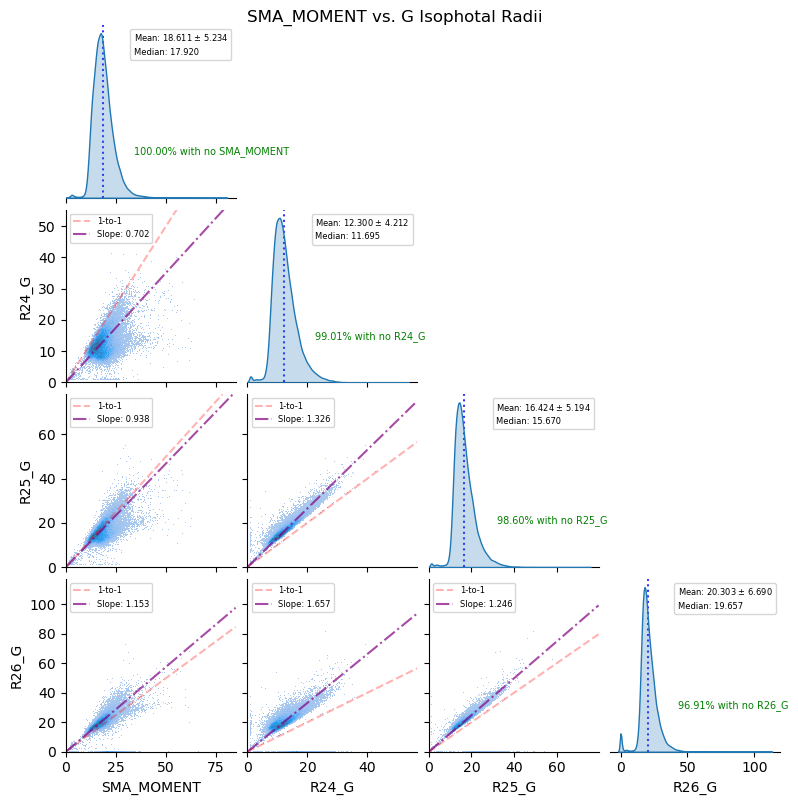

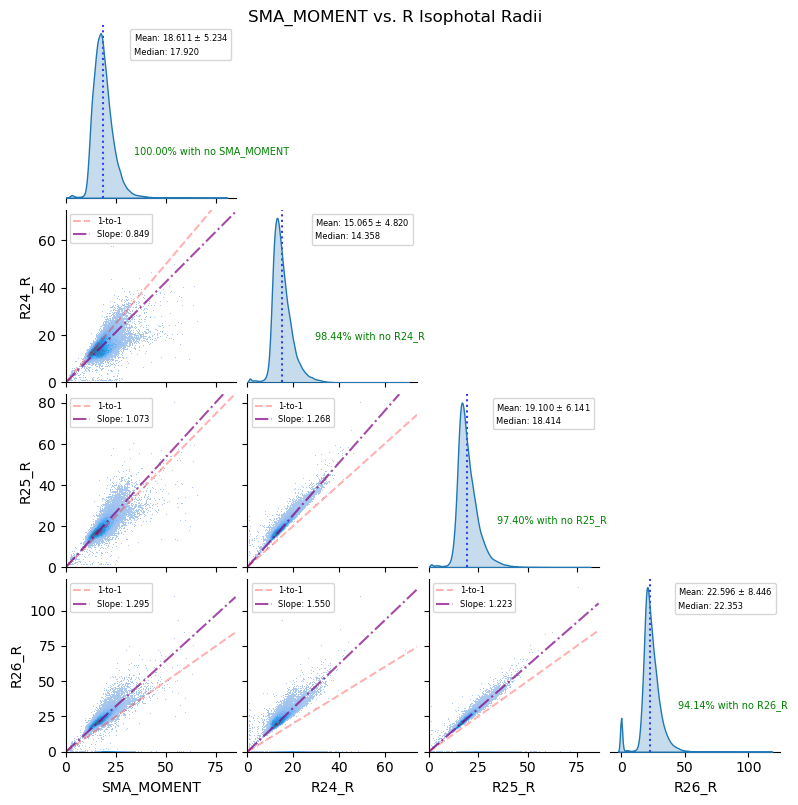

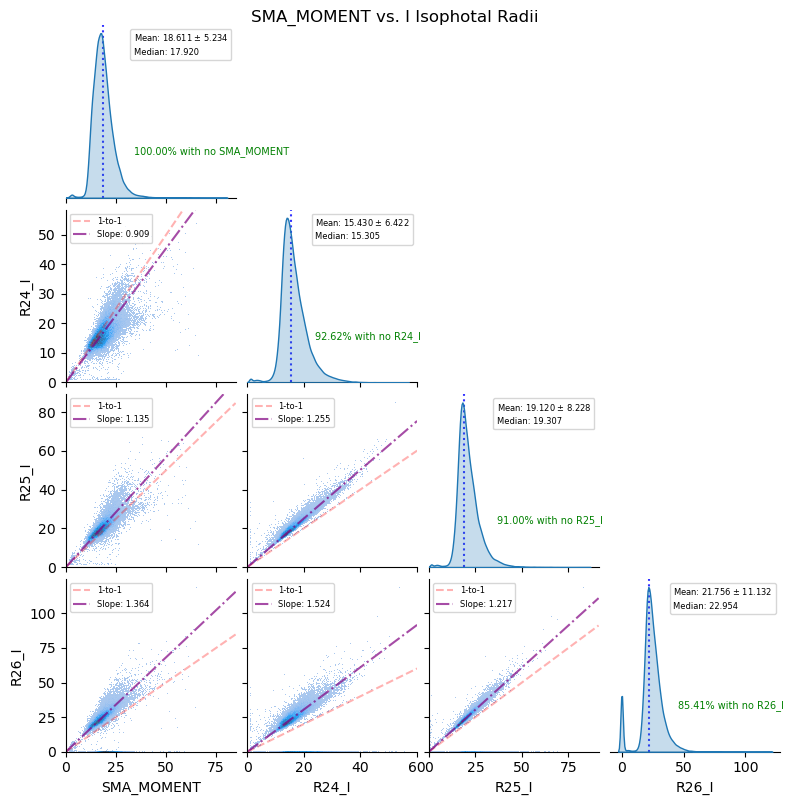

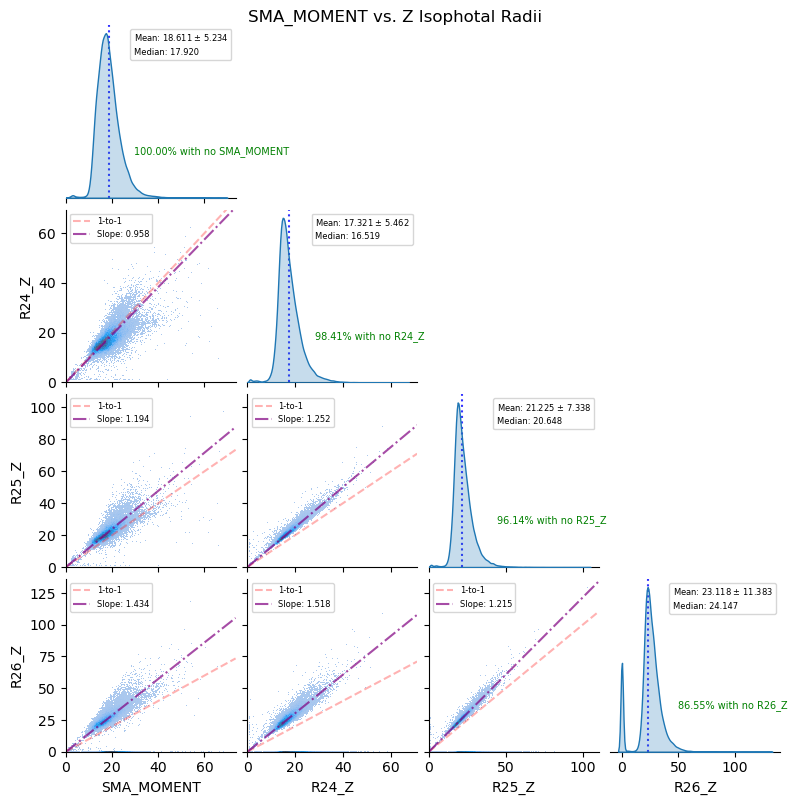

In [286]:
for band in ['G', 'R', 'I', 'Z']:
    generate_cornerplot(data_table=ellipse_tab, band=band)

### QA Ten
#### Plot R26_R [SGA2025] vs.  R26_R [SGA2020]
 - Want to ensure the adopted diameters for DR11 match the SGA-2020 D26 values in the mean
     - that is, check that the radii are not systematically offset

In [287]:
#remove instances where there is no data -- R26_R for SGA2020 or SGA2025 = 0
zero_flag = (sga2025_sga2020_tab['R26_R']>0) & (sga2025_sga2020_tab['sga2020_R26_R']>0)

In [288]:
r26_2020 = sga2025_sga2020_tab['sga2020_R26_R'][zero_flag]
r26_2025 = sga2025_sga2020_tab['R26_R'][zero_flag]

print('Matches:', len(r26_2020))

Matches: 81474

In [289]:
#difference
r26_ratio = r26_2025 / r26_2020
mean_ratio = np.mean(r26_ratio)
median_ratio = np.median(r26_ratio)
stdev_ratio = np.std(r26_ratio)

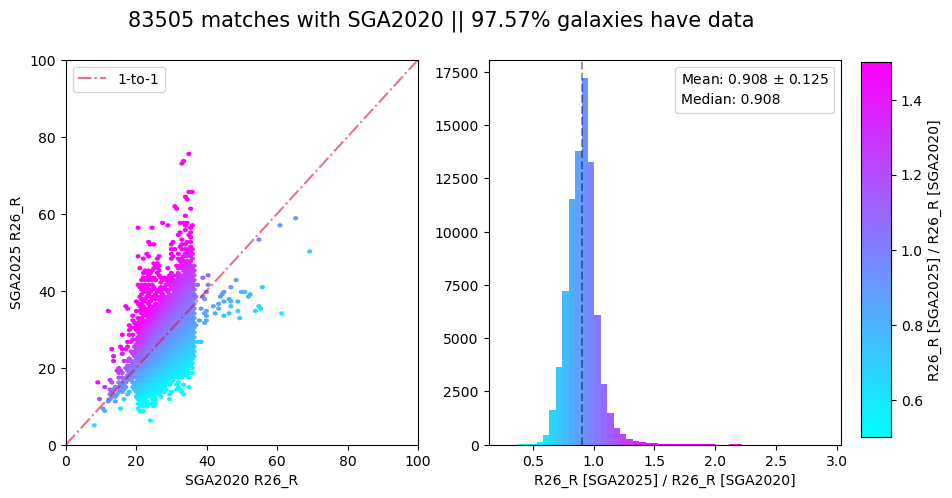

In [326]:
#plot for diagnostic purposes. which SG coordinate best correlates with redshift?
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

im1 = axs[0].hexbin(r26_2020, r26_2025, C=r26_ratio,
                    cmap='cool', vmin=0.5, vmax=1.5)#, edgecolor='lightgray')
axs[0].axline([0,0],slope=1,color='crimson',ls='-.',alpha=0.6,label='1-to-1')
axs[0].set_xlabel('SGA2020 R26_R')
axs[0].set_ylabel('SGA2025 R26_R')
axs[0].set_xlim(0,100)
axs[0].set_ylim(0,100)

axs[0].legend()

axs[1].axvline(mean_ratio,color='black',ls='--',alpha=0.4,
                   label=f'Mean: {mean_ratio:.3f} $\pm$ {stdev_ratio:.3f}')

axs[1].axvline(median_ratio,alpha=0,label=f'Median: {median_ratio:.3f}')

#axs[1].text(0.38, 0.4, f'{len(sga2025_sga2020_tab)} matches with SGA2020\n\n'
#                       f'{(len(sga2025_sga2020_tab[zero_flag])*100/(len(sga2025_sga2020_tab))):.2f}% have data',
#            transform=axs[1].transAxes, fontsize=10, color='blue')

axs[1].set_xlabel(f'R26_R [SGA2025] / R26_R [SGA2020]')
axs[1].legend(handlelength=0, handletextpad=0)   #the args remove the marker from the legend


###
#from matplotlib histogram documentation
###
N, bins, patches = axs[1].hist(r26_ratio, bins=50)

#normalize to min/max of data range
norm = colors.Normalize(vmin=0.5, vmax=1.5)
cmap = plt.cm.cool

#get bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])

#loop over bins, not raw data
for center, patch in zip(bin_centers, patches):
    patch.set_facecolor(cmap(norm(center)))
    
cbar_ax = fig.add_axes([0.92, 0.125, 0.03, 0.75]) 
cbar=fig.colorbar(im1, cax=cbar_ax)
cbar.set_label(f'R26_R [SGA2025] / R26_R [SGA2020]')
 
fig.suptitle(f'{len(sga2025_sga2020_tab)} matches with SGA2020 ||'
            f' {(len(sga2025_sga2020_tab[zero_flag])*100/(len(sga2025_sga2020_tab))):.2f}% galaxies have data',
            fontsize=15)    

plt.show()

#### Outliers

In [329]:
for i in range(len(r26_ratio)):
    if (np.abs(r26_ratio[i])>2.2) | (np.abs(r26_ratio[i])<0.42):
        sganame = sga2025_sga2020_tab['SGAID'][zero_flag][i]
        print(f'Outlier Galaxy: {sganame}') 
        print(f'Ratio: {r26_ratio[i]:.3f}')
        print()

Outlier Galaxy: 4711689

Ratio: 2.281

Outlier Galaxy: 4785236

Ratio: 0.397

Outlier Galaxy: 4789535

Ratio: 0.384

Outlier Galaxy: 4791440

Ratio: 0.269

Outlier Galaxy: 4815634

Ratio: 2.331

Outlier Galaxy: 4843765

Ratio: 2.689

Outlier Galaxy: 4865839

Ratio: 2.327

Outlier Galaxy: 4887558

Ratio: 2.202

Outlier Galaxy: 4899849

Ratio: 2.210

Outlier Galaxy: 4904586

Ratio: 0.398

Outlier Galaxy: 4937421

Ratio: 0.419

Outlier Galaxy: 4968736

Ratio: 2.902

Outlier Galaxy: 4975894

Ratio: 0.420

Outlier Galaxy: 4994300

Ratio: 0.390

Outlier Galaxy: 5004061

Ratio: 2.276